In [89]:
from eolearn.core import EOWorkflow, Dependency
from eolearn.core import FeatureType

In [90]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio.features
import rasterio.transform
import datetime
import os
from pathlib import Path
from math import ceil

from keras.utils import to_categorical

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [91]:
# testing
import scipy.stats as stats

In [92]:
from tqdm import tqdm_notebook as tqdm

In [93]:
from eolearn.core import LoadFromDisk, SaveToDisk, AddFeature, EOPatch, EOTask, FeatureTypeSet, FeatureType, LinearWorkflow, EOExecutor
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature
from eolearn.features import LinearInterpolation

In [94]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask

In [207]:
buffer = -5
fraction_size = 0.05 # koliksen del podatkov vzame
spatial = False
window = 1 # če je 1 je per pixel, drugače pa glede na velikost okna
interpolation_range = [8]#2,4,8,16,32,64,128] # [2,4,8] # [16, 32] # [2,4,8,16,32]
mask_valid = 'VALID_DATA' # L1C_VALID changed from VALID_DATA
#resampled_range = ('2017-01-01', '2017-09-30', interpolation)
drop_classes = [1,3,4,5,8,14,16,18,19,21]
class_labels = set(list(range(1,26))) - set(drop_classes)
MAIN_FOLDER = Path('/Volumes/Seagate_drive') # spremenis na path do podatkov zip-a
DATA_FOLDER = os.path.join(MAIN_FOLDER, 'original')
DATA_LIST = os.listdir(DATA_FOLDER)
#OUTPUT_FOLDER = os.path.join(MAIN_FOLDER, 'interpolation-{}days'.format(interpolation))

In [208]:
actual_fraction = fraction_size/(window*window)
print(actual_fraction, actual_fraction*(window**2))

0.05 0.05


In [209]:
non_empty_patches =[]
for name in DATA_LIST:
    if(name == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join(DATA_FOLDER, name), lazy_loading=True)
        if len(eopatch.data)!=0:
            non_empty_patches.append(name)
DATA_LIST = non_empty_patches

In [210]:
# DATA_LIST= DATA_LIST[:15]
print(len(DATA_LIST))
print(DATA_LIST)
# DATA_LIST = DATA_LIST[:15]
# DATA_LIST

213
['eopatch_100_col-8_row-7', 'eopatch_101_col-8_row-8', 'eopatch_102_col-8_row-9', 'eopatch_103_col-8_row-10', 'eopatch_107_col-9_row-3', 'eopatch_108_col-9_row-4', 'eopatch_109_col-9_row-5', 'eopatch_10_col-1_row-7', 'eopatch_110_col-9_row-6', 'eopatch_111_col-9_row-7', 'eopatch_112_col-9_row-8', 'eopatch_113_col-9_row-9', 'eopatch_114_col-9_row-10', 'eopatch_119_col-10_row-3', 'eopatch_120_col-10_row-4', 'eopatch_121_col-10_row-5', 'eopatch_122_col-10_row-6', 'eopatch_123_col-10_row-7', 'eopatch_124_col-10_row-8', 'eopatch_125_col-10_row-9', 'eopatch_126_col-10_row-10', 'eopatch_127_col-10_row-11', 'eopatch_12_col-1_row-9', 'eopatch_130_col-11_row-1', 'eopatch_131_col-11_row-2', 'eopatch_132_col-11_row-3', 'eopatch_133_col-11_row-4', 'eopatch_134_col-11_row-5', 'eopatch_135_col-11_row-6', 'eopatch_136_col-11_row-7', 'eopatch_137_col-11_row-8', 'eopatch_138_col-11_row-9', 'eopatch_139_col-11_row-10', 'eopatch_13_col-1_row-10', 'eopatch_140_col-11_row-11', 'eopatch_141_col-11_row-12

In [211]:
class bufferPolys(EOTask):
    
    def __init__(self, features, buffer):
        self.feature_type, self.feature_name = features[0], features[1]
        self.buffer = buffer
    
    def execute(self, eop):
        # crops = eopatch.vector_timeless['LPIS_2017']
        crops = eop[self.feature_type][self.feature_name]
        crops_buffered = crops.copy(deep=True)
        # make buffer = -5
        crops_buffered.geometry = crops.buffer(self.buffer)
        crops_buffered = crops_buffered[~crops_buffered.is_empty]
        crops_buffered['SIFRA_KMRS'] = pd.to_numeric(crops_buffered['SIFRA_KMRS'])

        eop.add_feature(FeatureType.VECTOR_TIMELESS, 'LPIS_buffered', crops_buffered)
        
        return eop

In [212]:
class VectorToRasterMultiple(EOTask):
    """
    Task burns into one of the EOPatch's features geo-referenced shapes given in provided Geopandas DataFrame.

    :param feature: A tuple of feature type and feature name, e.g. (FeatureType.MASK, 'cloud_mask')
    :type feature: (FeatureType, str)
    :param vector_data: Vector data
    :type vector_data: geopandas.GeoDataFrame
    :param raster_value: Value of raster pixels which are contained inside of vector polygons
    :type raster_value: int or float
    :param raster_shape: Can be a tuple in form of (height, width) of an existing feature from which the shape will be
                            taken e.g. (FeatureType.MASK, 'IS_DATA')
    :type raster_shape: (int, int) or (FeatureType, str)
    :param raster_dtype: `numpy` data type of the obtained raster array
    :type raster_dtype: numpy.dtype
    :param no_data_value: Value of raster pixels which are outside of vector polygons
    :type no_data_value: int or float
    :param kwargs: arguments passed to rasterio.features.rasterize
    """
    def __init__(self, feature, vector_feature, raster_value, raster_shape, raster_dtype=np.uint8, no_data_value=0,
                 **kwargs):
        self.feature_type, self.feature_name = next(iter(self._parse_features(feature)))
        self.vector_feature = vector_feature
        self.raster_value = raster_value
        self.raster_shape = raster_shape
        self.raster_dtype = raster_dtype
        self.no_data_value = no_data_value
        self.kwargs = kwargs

    def _get_submap(self, eopatch):
        """
        Returns a new geopandas dataframe with same structure as original one (columns) except that
        it contains only polygons that are contained within the given bbox.

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch
        :rtype: EOPatch
        """
#         bbox_poly = eopatch.bbox.get_geometry()
        bbox_poly = eopatch.bbox.geometry
        vector_data = eopatch[self.vector_feature[0]][self.vector_feature[1]]
        
        vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
        vector_data.geometry = vector_data.geometry.buffer(0)
        vetor_data = vector_data[vector_data.geometry.is_valid]
        vetor_data = vector_data[~vector_data.geometry.is_empty]
        
        filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        pairs = []
        for idx, row in filtered_data.iterrows():
            pairs.append((row.geometry, row[self.raster_value]))

        return pairs

    def _get_shape(self, eopatch):
        if isinstance(self.raster_shape, (tuple, list)) and len(self.raster_shape) == 2:
            if isinstance(self.raster_shape[0], int) and isinstance(self.raster_shape[1], int):
                return self.raster_shape

            feature_type, feature_name = next(self._parse_features(self.raster_shape)(eopatch))
            return eopatch.get_spatial_dimension(feature_type, feature_name)

        raise ValueError('Could not determine shape of the raster image')

    def execute(self, eopatch):
        """ Execute function which adds new vector layer to the EOPatch

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch with added vector layer
        :rtype: EOPatch
        """
        # print(eopatch)
        bbox_map = self._get_submap(eopatch)
        height, width = self._get_shape(eopatch)
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        if self.feature_name in eopatch[self.feature_type]:
            raster = eopatch[self.feature_type][self.feature_name].squeeze()
        else:
            raster = np.ones((height, width), dtype=self.raster_dtype) * self.no_data_value

        if len(bbox_map):
            rasterio.features.rasterize(bbox_map, out=raster,
                                        transform=data_transform,
                                        dtype=self.raster_dtype,
                                        **self.kwargs)

        eopatch[self.feature_type][self.feature_name] = raster[..., np.newaxis]

        return eopatch

In [213]:
class VectorToRasterMultiple2(EOTask):
    """
    Task burns into one of the EOPatch's features geo-referenced shapes given in provided Geopandas DataFrame.

    :param feature: A tuple of feature type and feature name, e.g. (FeatureType.MASK, 'cloud_mask')
    :type feature: (FeatureType, str)
    :param vector_data: Vector data
    :type vector_data: geopandas.GeoDataFrame
    :param raster_value: Value of raster pixels which are contained inside of vector polygons
    :type raster_value: int or float
    :param raster_shape: Can be a tuple in form of (height, width) of an existing feature from which the shape will be
                            taken e.g. (FeatureType.MASK, 'IS_DATA')
    :type raster_shape: (int, int) or (FeatureType, str)
    :param raster_dtype: `numpy` data type of the obtained raster array
    :type raster_dtype: numpy.dtype
    :param no_data_value: Value of raster pixels which are outside of vector polygons
    :type no_data_value: int or float
    :param kwargs: arguments passed to rasterio.features.rasterize
    """
    def __init__(self, feature, vector_feature, raster_value, raster_shape, raster_dtype=np.uint8, no_data_value=0,
                 **kwargs):
        self.feature_type, self.feature_name = next(iter(self._parse_features(feature)))
        self.vector_feature = vector_feature
        self.raster_value = raster_value
        self.raster_shape = raster_shape
        self.raster_dtype = raster_dtype
        self.no_data_value = no_data_value
        self.kwargs = kwargs

    def _get_submap(self, eopatch):
        """
        Returns a new geopandas dataframe with same structure as original one (columns) except that
        it contains only polygons that are contained within the given bbox.

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch
        :rtype: EOPatch
        """
#         bbox_poly = eopatch.bbox.get_geometry()
        bbox_poly = eopatch.bbox.geometry
        vector_data = eopatch[self.vector_feature[0]][self.vector_feature[1]]
        
        vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
        vector_data.geometry = vector_data.geometry.buffer(0)
        vetor_data = vector_data[vector_data.geometry.is_valid]
        vetor_data = vector_data[~vector_data.geometry.is_empty]
        
        filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        pairs = []
        for idx, row in filtered_data.iterrows():
            pairs.append((row.geometry, row[self.raster_value]))

        return pairs

    def execute(self, eopatch):
        """ Execute function which adds new vector layer to the EOPatch

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch with added vector layer
        :rtype: EOPatch
        """
        # print(eopatch)
        bbox_map = self._get_submap(eopatch)
        height = eopatch[FeatureType.MASK]['IS_DATA'].shape[1] * 10
        width = eopatch[FeatureType.MASK]['IS_DATA'].shape[2] * 10
        
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        if self.feature_name in eopatch[self.feature_type]:
            raster = eopatch[self.feature_type][self.feature_name].squeeze()
        else:
            raster = np.ones((height, width), dtype=self.raster_dtype) * self.no_data_value

        if len(bbox_map):
            rasterio.features.rasterize(bbox_map, out=raster,
                                        transform=data_transform,
                                        dtype=self.raster_dtype,
                                        **self.kwargs)

        eopatch[self.feature_type][self.feature_name] = raster[..., np.newaxis]

        return eopatch

In [214]:
class select_bands(EOTask):
    
    def __init__(self, feature, new_feature_name, features):
        self.feature_type, self.feature_name = feature[0], feature[1]
        self.new_feature_name = new_feature_name
        self.features = features
    
    def execute(self, eop):
        bands = eop[self.feature_type][self.feature_name]
        bands_new = bands[:, :, :, self.features]
        eop.add_feature(self.feature_type, self.new_feature_name, bands_new)
        
        return eop
    
class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch
    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch

In [215]:
def undersampleMajority(mask, rows, cols, fraction):
    sampled = np.random.rand(len(rows)) > (1.0 - fraction*2) # increase sample size by 2 to later reduce by 50%
    
    sampled_classes = mask[rows[sampled], cols[sampled]]
    # checking the distribution of mapped classes
    sampled_classes = np.array([get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled_classes])
    values = np.unique(sampled_classes, return_counts=True)
    number_of_2 = values[1][np.where(values[0]==2)[0]][0]
    
    for location, x in enumerate(sampled_classes):
        if x in drop_classes:
            sampled_classes[location] = 0
            
    clean = sampled_classes==0
    sampled_classes = sampled_classes[~clean]
    
    sampled2 = np.random.rand(number_of_2) > (1.0 - 1/6) # we want only 1/6 of them all
        
    sub_sample = np.where(sampled_classes==2)[0][~sampled2]
    sampled[np.where(sampled==True)[0][sub_sample]]=False
    
    #sampled_classes = mask[rows[sampled], cols[sampled]]
    #sampled_classes = np.array([get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled_classes])
    #values = np.unique(sampled_classes, return_counts=True)
    #distrib = np.round(values[1]/sum(values[1]), 6)
    #fig = plt.figure(figsize=(15, 15))
    #plt.bar(values[0], distrib, align='center')
    #plt.xticks(values[0], values[0]);
    
    return sampled

def sample(mask, rows, cols, fraction):
    sampled = np.random.rand(len(rows)) > (1.0 - fraction)
    return sampled

class SampleValid(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    def __init__(self, feature, fraction=1.0, no_data_value=0, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)

    def execute(self, in_eopatch, eopatch_folder, OUTPUT_FOLDER, seed=None):
        eopatch = in_eopatch.__copy__()
        #print(eopatch_folder)
        mask = eopatch[self.feature_type][self.feature_name].squeeze()

        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')
        
        rows, cols = np.where(mask != self.no_data_value)
        sampling_file = Path(os.path.join(OUTPUT_FOLDER, eopatch_folder, 'sampling.npy'))
        
        np.random.seed(seed)
        if not os.path.exists(os.path.join(OUTPUT_FOLDER, eopatch_folder)):
            os.makedirs(os.path.join(OUTPUT_FOLDER, eopatch_folder))
            
        if sampling_file.is_file():
            sampled = np.load(sampling_file)
            if not(round(np.sum(sampled)/len(rows), 2) == self.fraction):
                print("fraction mismatch")
                #sampled = undersampleMajority(mask, rows, cols, self.fraction)
                sampled = sample(mask, rows, cols, self.fraction)
                np.save(sampling_file, sampled)
            
        else:
            #sampled = undersampleMajority(mask, rows, cols, self.fraction)            
            sampled = sample(mask, rows, cols, self.fraction) 
            print("saving new fraction, file didn't exist")
            np.save(sampling_file, sampled)
            
        rows = rows[sampled]
        cols = cols[sampled]
        print(rows, cols)

        for feature_type, feature_name in self.sample_features(eopatch):

            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):

                if feature_type.is_time_dependent():
                    sampled_data = eopatch[feature_type][feature_name][:, rows, cols, :]
                else:
                    sampled_data = eopatch[feature_type][feature_name][rows, cols, :]

                # here a copy of sampled array is returned and assigned to feature of a shallow copy
                # orig_eopatch[feature_type][feature_name] remains unmodified
                eopatch[feature_type][feature_name] = sampled_data[..., np.newaxis, :]

        new_mask = np.ones_like(mask)*self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]        
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        return eopatch

In [216]:
class SampleValidSpatial(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    #def __init__(self, feature, fraction=1.0, window=24, no_data_value=0, increase=1, sample_features=...):
    def __init__(self, feature, fraction=1.0, window=1, no_data_value=0, increase=1, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)
        self.window = window
        self.increase = increase

    def sample_spatial(self, mask, rows, cols, fraction):

        # double the amount of sampled data to be reduced based on coverage
        sampled = np.random.rand(len(rows)) > (1.0 - self.fraction*self.increase)
        #print("sampled", np.sum(sampled), "which is", np.sum(sampled)/len(rows))
        # TODO save sampling        
        rows = rows[sampled]
        cols = cols[sampled]

        new_mask = np.array([mask[(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2))] for x,y in zip(rows,cols)])
        no_data_part = []        
        # to increase and reduce data where there is data
        if self.increase != 1:
            for x in new_mask:
                uniq = np.unique(x, return_counts=True)
                if self.no_data_value in uniq[0]:
                    number_of_0 = uniq[1][np.where(uniq[0]==self.no_data_value)[0]][0]
                    no_data_part.append(number_of_0/np.sum(uniq[1]))
                else: # in case all samples have label different from no_data_value
                    no_data_part.append(0)

            ordered = np.array(sorted(enumerate(no_data_part), key=lambda x:x[1]))
            to_keep = np.array(ordered[:(len(ordered)//self.increase),0], dtype= np.int16)
            #print(len(to_keep))
            new_mask = new_mask[to_keep]
            rows = rows[to_keep]
            cols = cols[to_keep]
        
        return rows, cols
       
    def sample_spatial_multi(self, in_eopatch, rows, cols):
        eopatch = in_eopatch.__copy__()
        print(in_eopatch)

        # insert magic here!
        numOfCellsAfterSampling = len(rows) 
        sampled_data = np.zeros((numOfCellsAfterSampling, 100, 1))

        for pair in range(0, len(rows)):
            for i in range(0, 10):
                for j in range(0, 10):
                    sampled_data[pair][i + j*10][0] = eopatch['mask_timeless']['LPIS_multi'][(rows[pair] * 10) + i][(cols[pair] * 10) + j][0]

        return sampled_data
    
    def execute(self, in_eopatch, eopatch_folder, OUTPUT_FOLDER, seed=None):
        eopatch = in_eopatch.__copy__()
        
         # ------------------from sampling valid
        mask = eopatch[self.feature_type][self.feature_name].squeeze()
        h, w = mask.shape
        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')

        np.random.seed(int(eopatch_folder.split('_')[1]))
        increase = 1
        rows1, cols1 = np.where(mask != self.no_data_value)
        # moving towards the inside of the patch so patch is defined in sampled area
        clean = np.logical_and(rows1>=self.window//2, rows1<=(h-ceil(self.window/2)))
        # #print("bounds x", len(rows)-np.sum(clean))
        rows1 = rows1[clean]
        cols1 = cols1[clean]
        clean = np.logical_and(cols1>=self.window//2, cols1<=(w-ceil(self.window/2)))
        #print("bounds y", len(cols)-np.sum(clean))
        rows1 = rows1[clean]
        cols1 = cols1[clean]
        

               
        sampling_file = Path(os.path.join(OUTPUT_FOLDER, eopatch_folder+'sampling.npy'))
        np.random.seed(seed)
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
            
        if sampling_file.is_file(): # not loading fraction beacause just one interpolation sampling_file.is_file():
            rows, cols = np.load(sampling_file, allow_pickle=True)
            if not(round(len(rows)/len(rows1), 3) == self.fraction):
                print("fraction mismatch", round(len(rows)/len(rows1), 3), self.fraction)
                #rows, cols = self.sample_spatial(mask, rows1, cols1, self.fraction)
                #np.save(sampling_file, (rows, cols))
            
        else:
            rows, cols = self.sample_spatial(mask, rows1, cols1, self.fraction) 
            print("saving new fraction, file didn't exist")
            np.save(sampling_file, (rows, cols))
            
        #rows = rows[sampled]
        #cols = cols[sampled] #empty
        
        for feature_type, feature_name in self.sample_features(eopatch):
            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):
                if feature_type.is_time_dependent():
                    sampled_data = np.array([eopatch[feature_type][feature_name][:,(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2)), :] for x,y in zip(rows,cols)])
                    sampled_data = np.transpose(sampled_data, (1, 0, 2, 3, 4))
                    t,s,wi,he,b = sampled_data.shape
                    sampled_data = sampled_data.reshape(t,s,wi*he,b)
                else:
                    sampled_data = np.array([eopatch[feature_type][feature_name][(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2)), :] for x,y in zip(rows,cols)])
                    s,wi,he,b = sampled_data.shape
                    sampled_data = sampled_data.reshape(s,wi*he,b)
        
                eopatch[feature_type][feature_name] = sampled_data
        
        #print(list(zip(rows, cols))[:10])
        #print(mask[rows[:10], cols[:10]])
        new_mask = np.ones_like(mask)*self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]
        
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        sampled_data_multi = self.sample_spatial_multi(in_eopatch, rows, cols)
        eopatch['mask_timeless']['LPIS_multi'] = sampled_data_multi
        
        # eopatch.save('./temp_eopatch_after_sampling', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

        return eopatch

In [217]:
def crops_to_groups_multi(in_eopatch):
    # group definition 
    beets1_set = [101, 19]
    meadows2_set = [204]
    fallow_land3_set = [26]
    peas4_set = [44, 33, 833]
    pasture5_set = []
    hop6_set = [900]
    grass7_set = [118, 505, 201, 200, 202, 117]
    poppy8_set = [31, 831]
    winter_rape9_set = [812, 814]
    maize10_set = [6, 5, 109, 49]
    winter_cereals11_set = [809, 808, 803, 801, 802, 24, 825, 807]
    leafy_legumes12_set = [220, 207, 206, 219, 211, 222, 208, 223, 221, 203]
    pumpkins13_set = [42, 13]
    soft_fruits14_set = [652, 681, 657, 679, 656, 660, 659, 651, 653, 655, 662, 654, 678]
    summer_cereals15_set = [9, 11, 811, 8, 3, 10, 1, 2, 25, 7]
    sunflower16_set = [12]
    vegetables17_set = [46, 47, 48, 402]
    buckwheat18_set = [4]
    alpine_meadows19_set = []
    potatoes20_set = [20]
    beans21_set = [45, 17]
    vineyards22_set = [707, 661, 706, 100]
    other23_set = [115, 37, 738, 733, 648, 32, 111, 646, 555, 43, 675, 702, 114, 721, 619, 615, 110, 810,
                720, 35, 835, 27, 112, 102, 104, 804, 105, 106, 107, 28, 40, 41, 405, 710, 699, 705, 409,
                506, 722, 999, 904, '204_a', 0, 888, 404, 735, 14, 113, 103, 108, 777, 734, 649, 403, 36,
                34, 998, 737, 677, 21, 821, 116, 680, 703, 333, 723, 704, 29, 210, 736]
    soybean24_set = [30]
    orchards25_set = [621, 625, 672, 612, 611, 627, 643, 642, 676, 644, 613, 632, 671, 674, 633, 624, 658,
                614, 622, 616, 800, 631, 698, 673, 623, 647, 626, 618]
    
    tmp_patch = in_eopatch.__copy__()
    num_of_cells = tmp_patch['mask_timeless']['LPIS_multi'].shape[0]
    out_arr = np.zeros((num_of_cells, 100, 1))
    for i in range(0, num_of_cells):
        for j in range(0, 100):
            val = tmp_patch['mask_timeless']['LPIS_multi'][i][j][0]

            if(val in beets1_set):
                out_arr[i][j][0] = 1
            elif(val in meadows2_set):
                out_arr[i][j][0] = 2
            elif(val in fallow_land3_set):
                out_arr[i][j][0] = 3
            elif(val in peas4_set):
                out_arr[i][j][0] = 4
            elif(val in pasture5_set):
                out_arr[i][j][0] = 5
            elif(val in hop6_set):
                out_arr[i][j][0] = 6
            elif(val in grass7_set):
                out_arr[i][j][0] = 7
            elif(val in poppy8_set):
                out_arr[i][j][0] = 8
            elif(val in winter_rape9_set):
                out_arr[i][j][0] = 9
            elif(val in maize10_set):
                out_arr[i][j][0] = 10
            elif(val in winter_cereals11_set):
                out_arr[i][j][0] = 11
            elif(val in leafy_legumes12_set):
                out_arr[i][j][0] = 12
            elif(val in pumpkins13_set):
                out_arr[i][j][0] = 13
            elif(val in soft_fruits14_set):
                out_arr[i][j][0] = 14
            elif(val in summer_cereals15_set):
                out_arr[i][j][0] = 15
            elif(val in sunflower16_set):
                out_arr[i][j][0] = 16
            elif(val in vegetables17_set):
                out_arr[i][j][0] = 17
            elif(val in buckwheat18_set):
                out_arr[i][j][0] = 18
            elif(val in alpine_meadows19_set):
                out_arr[i][j][0] = 19
            elif(val in potatoes20_set):
                out_arr[i][j][0] = 20
            elif(val in beans21_set):
                out_arr[i][j][0] = 21
            elif(val in vineyards22_set):
                out_arr[i][j][0] = 22
            elif(val in other23_set):
                out_arr[i][j][0] = 23
            elif(val in soybean24_set):
                out_arr[i][j][0] = 24
            elif(val in orchards25_set):
                out_arr[i][j][0] = 25
            else:
                print('CROP GROUP NOT FOUND: ',tmp_patch['mask_timeless']['LPIS_multi'][i][j][0])
                
    return out_arr

In [218]:
def get_group_id(crop_group, crop_group_df, group_name='CROP_ID',
             group_id='GROUP_1', default_value=0):
    """
    Returns numeric crop group value for specified crop group name. The mapping is obtained from
    the specified crop group pandas DataFrame.
    """
    values = crop_group_df[crop_group_df[group_name]==crop_group][group_id].values
    if len(values)==0:
        return default_value
    else:
        return values[-1]

def get_numeric_group(crop_group, crop_group_df, group_name='GROUP_1_NAME',
                 group_id='GROUP_1_ID', default_value=0):
    """
    Returns numeric crop group value for specified crop group name. The mapping is obtained from
    the specified crop group pandas DataFrame.
    """
    values = crop_group_df[crop_group_df[group_name]==crop_group][group_id].values
    if len(values)==0:
        return default_value
    else:
        return values[-1]

class group_crops_spatial(EOTask):
    def __init__(self, lpis_to_group, group_to_numeric):
        self.lpis_to_group = lpis_to_group
        self.group_to_numeric = group_to_numeric
    
    def execute(self, eop):
        arr = []
        if eop.mask_timeless['LPIS_sifra'].shape[1] == 1:
               arr = [[get_numeric_group(get_group_id(str(y).zfill(3), self.lpis_to_group), self.group_to_numeric)] for y in eop.mask_timeless['LPIS_sifra'].squeeze()]
        else: 
            for y in eop.mask_timeless['LPIS_sifra'].squeeze():
                arr.append([get_numeric_group(get_group_id(str(x).zfill(3), self.lpis_to_group), self.group_to_numeric) for x in y])
                    #print(np.unique(arr[-1], return_counts=True))
                #break
        #print(eop.mask_timeless['LPIS_sifra'].squeeze()[np.where(np.array(arr) == 23)])
        arr = np.array(arr)
        #aar shape[1] is 1 when no spatial data is included
        eop.mask_timeless['LPIS_sifra'] = arr[...,np.newaxis]
        #print(np.unique(arr, return_counts=True))
        
        eop.mask_timeless['LPIS_multi_grouped_crops'] = crops_to_groups_multi(eop)
        
        return eop
    
class group_crops(EOTask):
    def __init__(self, lpis_to_group, group_to_numeric):
        self.lpis_to_group = lpis_to_group
        self.group_to_numeric = group_to_numeric
    
    def execute(self, eop):
        # print(np.unique(eop.mask_timeless['LPIS_sifra'], return_counts=True))
        groups = list(get_group_id(str(x).zfill(3), self.lpis_to_group) for x in eop.mask_timeless['LPIS_sifra'].squeeze())
        # print(np.unique(groups, return_counts=True))
        tt = np.array([get_numeric_group(x, self.group_to_numeric) for x in groups])
             # np.array(list(get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled.mask_timeless['LPIS_sifra']))
        # print(np.unique(tt, return_counts=True))
        eop.mask_timeless['LPIS_sifra'] = tt.reshape([len(tt),1,1])
        # eop.data['BANDS-S2-L2A'] = np.squeeze(eop.data['BANDS-S2-L2A'], axis=2)
        # eop.mask_timeless['PID'] = np.squeeze(eop.mask_timeless['PID'])
        return eop

In [219]:
buffer_poly = bufferPolys((FeatureType.VECTOR_TIMELESS, 'LPIS_2017_org'), buffer)

load = LoadFromDisk(folder=DATA_FOLDER, lazy_loading=True)


vec_to_ras_lpis = VectorToRasterMultiple((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'SIFRA_KMRS', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint16, no_data_value=0)

vec_to_multi_raster = VectorToRasterMultiple2((FeatureType.MASK_TIMELESS, 'LPIS_multi'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'SIFRA_KMRS', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint16, no_data_value=0)

vec_to_ras_pid = VectorToRasterMultiple((FeatureType.MASK_TIMELESS, 'PID'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'GERK_PID', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint32, no_data_value=0)


# [(FeatureType.DATA, 'BANDS-S2-L2A'), (FeatureType.MASK, mask_valid), FeatureType.MASK_TIMELESS])
sampling = SampleValidSpatial((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                              fraction=actual_fraction, no_data_value=0,
                              window=window, increase=2,
                              sample_features=[(FeatureType.DATA, 'BANDS-S2-L2A'),
                                               (FeatureType.MASK, mask_valid),
                                               (FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                                               (FeatureType.MASK_TIMELESS, 'PID')])



#B(B02), G(B03), R(B04), NIR (B08)
custom_bands = [2, 3, 4, 8]
select = select_bands((FeatureType.DATA, 'BANDS-S2-L2A'), 'BANDS', custom_bands)

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

lpis_to_group = pd.read_csv("/Volumes/Seagate_drive/crop-definitions/slo_lpis_crop_to_group_mapping_20190517.csv")
group_to_numeric = pd.read_csv("/Volumes/Seagate_drive/crop-definitions/crop_group_1_definition_20190517.csv")
grouping = group_crops_spatial(lpis_to_group, group_to_numeric)
grouping_multi = group_crops_spatial_multi(lpis_to_group, group_to_numeric)

/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/core_tasks.py:166: DeprecationWarning: This task is deprecated, use LoadTask instead
  warnings.warn('This task is deprecated, use LoadTask instead', DeprecationWarning)


In [220]:
# save for different interpolations
print(str(window) +'_' + str(int(actual_fraction*(window**2)*100)).zfill(2))
for interpolation in interpolation_range[::-1]:
    resampled_range = ('2017-01-01', '2017-09-30', interpolation)
    OUTPUT_FOLDER = os.path.join("/Volumes/Seagate_drive", 'aFractionIndices{}'.format(str(window)+'_'+str(int(actual_fraction*(window**2)*100)).zfill(2)),  'interpolation-{}days'.format(interpolation))
#     OUTPUT_FOLDER = os.path.join("./", 'aFractionIndices{}'.format(str(window)+'_'+str(int(actual_fraction*(window**2)*100)).zfill(2)),  'interpolation-{}days'.format(interpolation))
    
    # workflow
    linear_interp = LinearInterpolation(
        (FeatureType.DATA,'FEATURES'), # 'BANDS-S2-L2A'
        mask_feature=(FeatureType.MASK, mask_valid), # mask to be used in interpolation TODO change from VALID_DATA
        copy_features=[(FeatureType.MASK_TIMELESS, 'LPIS_sifra'), (FeatureType.MASK_TIMELESS, 'LPIS_multi'), (FeatureType.MASK_TIMELESS, 'PID')], # features to keep
        resample_range=resampled_range, # set the resampling range
        bounds_error=False # extrapolate with NaN's
    )

    save = SaveToDisk(OUTPUT_FOLDER, overwrite_permission = 1)
    exec_params = []
    for name in DATA_LIST:  # [filename for filename in DATA_LIST if 'col-21_row-20' in filename]:
        #name = filename.rsplit('/', 1)[1]
        exec_params.append({
            load: dict(eopatch_folder=name),
            save: dict(eopatch_folder=name),
            sampling: dict(eopatch_folder=name, OUTPUT_FOLDER=OUTPUT_FOLDER)
        })
    
    workflow = LinearWorkflow(load, buffer_poly, vec_to_ras_lpis, vec_to_multi_raster, vec_to_ras_pid, sampling, select, ndvi, ndwi, norm, concatenate, linear_interp, grouping, save)
    executor = EOExecutor(workflow, exec_params, save_logs=True)
    print("Working on", interpolation, "days,", "saving to", OUTPUT_FOLDER)
    executor.run(workers=1)
#     workflow.execute(exec_params[0])

1_05
Working on 8 days, saving to /Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days


/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/core_tasks.py:127: DeprecationWarning: This task is deprecated, use SaveTask instead
  warnings.warn('This task is deprecated, use SaveTask instead', DeprecationWarning)


DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_100_col-8_row-7'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_100_col-8_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_100_col-8_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_100_col-8_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_100_col-8_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_100_col-8_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_100_col-8_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_100_col-8_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_100_col-8_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_100_col-8_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_20

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c7fbdd8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ddfa7b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ddfa7b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c7fbdd8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c7fbdd8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ddfa7b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ddfa7b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c7fbdd8>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

/Users/markbogataj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 5180, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 5180, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_time

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 5180, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 5180, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 5180, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 5180, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 5180, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 5180, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5180, 

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SaveToDisk
DEBUG:eolearn.core.eoworkflow:Workflow finished with WorkflowResults(
  Dependency(SaveToDisk):
    EOPatch(
      data: {
        FEATURES: numpy.ndarray(shape=(34, 5180, 1, 7), dtype=float64)
      }
      mask: {}
      scalar: {}
      label: {}
      vector: {}
      data_timeless: {}
      mask_timeless: {
        LPIS_multi: numpy.ndarray(shape=(5180, 100, 1), dtype=float64)
        LPIS_multi_grouped_crops: numpy.ndarray(shape=(5180, 100, 1), dtype=float64)
        LPIS_sifra: numpy.ndarray(shape=(5180, 1, 1), dtype=int64)
        PID: numpy.ndarray(shape=(5180, 1, 1), dtype=uint32)
      }
      scalar_timeless: {}
      label_timeless: {}
      vector_timeless: {}
      meta_info: {}
      bbox: BBox(((451581.91665190033, 5096370.648638509), (461269.3104915918, 5105816.813818144)), crs=CRS('32633'))
      timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length

DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69f89be0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a622668>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple2
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_101_col-8_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_101_col-8_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_101_col-8_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_101_col-8_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_101_col-8_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_101_col-8_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=u

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 10822, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 10822, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10822, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10822, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10822, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 10822, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 10822, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 10822, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 10822, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 10822, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 10822, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_102_col-8_row-9'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_102_col-8_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_102_col-8_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_102_col-8_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_102_col-8_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_102_col-8_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_102_col-8_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_102_col-8_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_102_col-8_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_102_col-8_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_20

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c69f27b00>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e053eb8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e053eb8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c69f27b00>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c69f27b00>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e053eb8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e053eb8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c69f27b00>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 14167, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 14167, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(14167, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(14167, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(14167, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 14167, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 14167, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 14167, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 14167, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 14167, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 14167, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_103_col-8_row-10'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_103_col-8_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_103_col-8_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_103_col-8_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_103_col-8_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_103_col-8_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_103_col-8_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_103_col-8_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_103_col-8_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_103_col-8_row-10/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70725f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69fa13c8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69fa13c8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70725f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70725f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69fa13c8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69fa13c8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70725f60>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 4644, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 4644, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4644, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4644, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4644, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 4644, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 4644, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 4644, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 4644, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 4644, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 4644, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4644, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_107_col-9_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_107_col-9_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_107_col-9_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_107_col-9_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_107_col-9_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_107_col-9_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_107_col-9_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_107_col-9_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_107_col-9_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_107_col-9_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6dbd3940>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dd79fd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dd79fd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6dbd3940>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6dbd3940>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dd79fd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dd79fd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6dbd3940>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 5492, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 5492, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5492, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5492, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5492, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 5492, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 5492, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 5492, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 5492, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 5492, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 5492, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5492, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_108_col-9_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_108_col-9_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_108_col-9_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_108_col-9_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_108_col-9_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_108_col-9_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_108_col-9_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_108_col-9_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_108_col-9_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_108_col-9_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ca0ba58>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dc53f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dc53f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ca0ba58>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ca0ba58>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dc53f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dc53f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ca0ba58>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 6962, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 6962, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6962, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6962, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6962, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 6962, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 6962, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 6962, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 6962, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 6962, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 6962, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6962, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_109_col-9_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_109_col-9_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_109_col-9_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_109_col-9_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_109_col-9_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_109_col-9_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_109_col-9_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_109_col-9_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_109_col-9_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_109_col-9_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d8fe1d0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c599fc860> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c599fc860>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d8fe1d0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d8fe1d0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c599fc860> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c599fc860>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d8fe1d0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 3928, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 3928, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3928, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3928, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3928, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 3928, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 3928, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 3928, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 3928, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 3928, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 3928, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3928, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_10_col-1_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_10_col-1_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_10_col-1_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_10_col-1_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_10_col-1_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_10_col-1_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_10_col-1_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_10_col-1_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_10_col-1_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_10_col-1_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d7aac18>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d7aadd8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d7aadd8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d7aac18>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d7aac18>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d7aadd8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d7aadd8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d7aac18>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 2113, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 2113, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2113, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2113, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2113, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(32, 2113, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 2113, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(32, 2113, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(32, 2113, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(32, 2113, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 2113, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2113, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_110_col-9_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_110_col-9_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_110_col-9_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_110_col-9_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_110_col-9_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_110_col-9_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_110_col-9_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_110_col-9_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_110_col-9_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_110_col-9_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a020710>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a020be0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a020be0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a020710>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a020710>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a020be0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a020be0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a020710>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 11572, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 11572, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11572, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11572, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11572, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 11572, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 11572, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 11572, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 11572, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 11572, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 11572, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_111_col-9_row-7'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_111_col-9_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_111_col-9_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_111_col-9_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_111_col-9_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_111_col-9_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_111_col-9_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_111_col-9_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_111_col-9_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_111_col-9_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_20

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d48d6a0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d48d710> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d48d710>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d48d6a0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d48d6a0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d48d710> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d48d710>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d48d6a0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 6413, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 6413, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6413, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6413, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6413, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 6413, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 6413, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 6413, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 6413, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 6413, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 6413, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6413, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_112_col-9_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_112_col-9_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_112_col-9_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_112_col-9_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_112_col-9_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_112_col-9_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_112_col-9_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_112_col-9_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_112_col-9_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_112_col-9_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d582f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ca6a550> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca6a550>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d582f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d582f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ca6a550> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca6a550>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d582f60>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 12051, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 12051, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(12051, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(12051, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(12051, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 12051, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 12051, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 12051, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 12051, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 12051, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 12051, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_113_col-9_row-9'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_113_col-9_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_113_col-9_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_113_col-9_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_113_col-9_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_113_col-9_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_113_col-9_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_113_col-9_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_113_col-9_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_113_col-9_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_20

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6edb0d68>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c7b0358> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c7b0358>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6edb0d68>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6edb0d68>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c7b0358> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c7b0358>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6edb0d68>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 11435, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 11435, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11435, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11435, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11435, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 11435, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 11435, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 11435, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 11435, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 11435, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 11435, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_114_col-9_row-10'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_114_col-9_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_114_col-9_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_114_col-9_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_114_col-9_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_114_col-9_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_114_col-9_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_114_col-9_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_114_col-9_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_114_col-9_row-10/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c56657d68>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c56657ef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c56657ef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c56657d68>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c56657d68>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c56657ef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c56657ef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c56657d68>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(5, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(5, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(5, 2060, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(5, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(5, 2060, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2060, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2060, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2060, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(5, 2060, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(5, 2060, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(5, 2060, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(5, 2060, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(5, 2060, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(5, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(5, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(5, 2060, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2060, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_119_col-10_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_119_col-10_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_119_col-10_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_119_col-10_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_119_col-10_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_119_col-10_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_119_col-10_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_119_col-10_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_119_col-10_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_119_col-10_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d30f780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cbedba8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cbedba8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d30f780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d30f780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cbedba8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cbedba8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d30f780>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 3955, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 3955, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3955, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3955, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3955, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 3955, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 3955, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 3955, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 3955, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 3955, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 3955, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3955, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_120_col-10_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_120_col-10_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_120_col-10_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_120_col-10_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_120_col-10_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_120_col-10_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_120_col-10_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_120_col-10_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_120_col-10_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_120_col-10_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e23e0f0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d147ac8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d147ac8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e23e0f0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e23e0f0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d147ac8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d147ac8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e23e0f0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 6560, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 6560, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6560, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6560, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6560, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 6560, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 6560, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 6560, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 6560, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 6560, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 6560, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6560, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_121_col-10_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_121_col-10_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_121_col-10_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_121_col-10_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_121_col-10_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_121_col-10_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_121_col-10_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_121_col-10_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_121_col-10_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_121_col-10_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d9a0c88>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d934fd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d934fd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d9a0c88>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d9a0c88>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d934fd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d934fd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d9a0c88>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 4689, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 4689, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4689, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4689, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4689, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 4689, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 4689, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 4689, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 4689, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 4689, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 4689, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4689, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_122_col-10_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_122_col-10_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_122_col-10_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_122_col-10_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_122_col-10_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_122_col-10_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_122_col-10_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_122_col-10_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_122_col-10_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_122_col-10_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e23eb00>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6da8b1d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6da8b1d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e23eb00>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e23eb00>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6da8b1d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6da8b1d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e23eb00>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 8495, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 8495, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8495, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8495, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8495, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(9, 8495, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 8495, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(9, 8495, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(9, 8495, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(9, 8495, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 8495, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8495, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_123_col-10_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_123_col-10_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_123_col-10_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_123_col-10_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_123_col-10_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_123_col-10_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_123_col-10_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_123_col-10_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_123_col-10_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_123_col-10_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a568da0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d83a390> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d83a390>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a568da0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a568da0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d83a390> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d83a390>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a568da0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 4875, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 4875, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4875, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4875, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4875, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 4875, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 4875, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 4875, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 4875, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 4875, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 4875, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4875, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_124_col-10_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_124_col-10_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_124_col-10_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_124_col-10_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_124_col-10_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_124_col-10_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_124_col-10_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_124_col-10_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_124_col-10_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_124_col-10_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c59a1ee10>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d9e9f60> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d9e9f60>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c59a1ee10>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c59a1ee10>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d9e9f60> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d9e9f60>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c59a1ee10>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 9867, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 9867, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9867, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9867, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9867, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 9867, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 9867, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 9867, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 9867, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 9867, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 9867, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9867, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_125_col-10_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_125_col-10_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_125_col-10_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_125_col-10_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_125_col-10_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_125_col-10_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_125_col-10_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_125_col-10_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_125_col-10_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_125_col-10_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d7ac780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d64f160> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d64f160>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d7ac780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d7ac780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d64f160> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d64f160>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d7ac780>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 5850, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 5850, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5850, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5850, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5850, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 5850, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 5850, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 5850, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 5850, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 5850, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 5850, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5850, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_126_col-10_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_126_col-10_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_126_col-10_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_126_col-10_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_126_col-10_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_126_col-10_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_126_col-10_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_126_col-10_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_126_col-10_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_126_col-10_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5a5b70>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a4b32b0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a4b32b0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5a5b70>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5a5b70>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a4b32b0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a4b32b0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5a5b70>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 5048, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 5048, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5048, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5048, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5048, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 5048, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 5048, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 5048, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 5048, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 5048, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 5048, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5048, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_127_col-10_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_127_col-10_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_127_col-10_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_127_col-10_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_127_col-10_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_127_col-10_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_127_col-10_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_127_col-10_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_127_col-10_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_127_col-10_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c562ffc18>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55d89c88> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55d89c88>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c562ffc18>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c562ffc18>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55d89c88> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55d89c88>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c562ffc18>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2066, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2066, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2066, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2066, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2066, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 2066, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2066, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 2066, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 2066, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 2066, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2066, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2066, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_12_col-1_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_12_col-1_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_12_col-1_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_12_col-1_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_12_col-1_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_12_col-1_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_12_col-1_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_12_col-1_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_12_col-1_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_12_col-1_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ed7ddd8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ed7dcc0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ed7dcc0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ed7ddd8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ed7ddd8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ed7dcc0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ed7dcc0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ed7ddd8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(22, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(22, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(22, 4059, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(22, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(22, 4059, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4059, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4059, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4059, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(22, 4059, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(22, 4059, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(22, 4059, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(22, 4059, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(22, 4059, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(22, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(22, 4059, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4059, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_130_col-11_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_130_col-11_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_130_col-11_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_130_col-11_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_130_col-11_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_130_col-11_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_130_col-11_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_130_col-11_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_130_col-11_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_130_col-11_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c56d15ba8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c54f8d4a8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c54f8d4a8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c56d15ba8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c56d15ba8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c54f8d4a8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c54f8d4a8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c56d15ba8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2630, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2630, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2630, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2630, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2630, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 2630, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2630, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 2630, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 2630, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 2630, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2630, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2630, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_131_col-11_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_131_col-11_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_131_col-11_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_131_col-11_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_131_col-11_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_131_col-11_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_131_col-11_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_131_col-11_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_131_col-11_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_131_col-11_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c55eba6a0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c54c5efd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c54c5efd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c55eba6a0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c55eba6a0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c54c5efd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c54c5efd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c55eba6a0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 3748, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 3748, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3748, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3748, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3748, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(9, 3748, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 3748, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(9, 3748, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(9, 3748, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(9, 3748, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 3748, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3748, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_132_col-11_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_132_col-11_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_132_col-11_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_132_col-11_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_132_col-11_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_132_col-11_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_132_col-11_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_132_col-11_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_132_col-11_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_132_col-11_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7099c198>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7099c518> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7099c518>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7099c198>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7099c198>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7099c518> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7099c518>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7099c198>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2682, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2682, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2682, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2682, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2682, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 2682, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2682, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 2682, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 2682, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 2682, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2682, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2682, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_133_col-11_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_133_col-11_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_133_col-11_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_133_col-11_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_133_col-11_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_133_col-11_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_133_col-11_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_133_col-11_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_133_col-11_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_133_col-11_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cbe2d68>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c704d8f28> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c704d8f28>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cbe2d68>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cbe2d68>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c704d8f28> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c704d8f28>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cbe2d68>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 3121, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 3121, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3121, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3121, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3121, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 3121, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 3121, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 3121, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 3121, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 3121, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 3121, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3121, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_134_col-11_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_134_col-11_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_134_col-11_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_134_col-11_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_134_col-11_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_134_col-11_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_134_col-11_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_134_col-11_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_134_col-11_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_134_col-11_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e3335c0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d1340b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d1340b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e3335c0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e3335c0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d1340b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d1340b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e3335c0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 7215, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 7215, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7215, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7215, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7215, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 7215, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 7215, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 7215, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 7215, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 7215, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 7215, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7215, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_135_col-11_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_135_col-11_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_135_col-11_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_135_col-11_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_135_col-11_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_135_col-11_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_135_col-11_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_135_col-11_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_135_col-11_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_135_col-11_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c69fe9400>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69fe9940> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69fe9940>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c69fe9400>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c69fe9400>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69fe9940> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69fe9940>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c69fe9400>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8590, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8590, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8590, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8590, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8590, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 8590, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8590, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 8590, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 8590, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 8590, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8590, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8590, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_136_col-11_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_136_col-11_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_136_col-11_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_136_col-11_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_136_col-11_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_136_col-11_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_136_col-11_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_136_col-11_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_136_col-11_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_136_col-11_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c706d06a0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c706d0f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c706d0f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c706d06a0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c706d06a0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c706d0f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c706d0f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c706d06a0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 6681, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 6681, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6681, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6681, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6681, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(9, 6681, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 6681, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(9, 6681, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(9, 6681, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(9, 6681, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 6681, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6681, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_137_col-11_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_137_col-11_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_137_col-11_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_137_col-11_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_137_col-11_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_137_col-11_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_137_col-11_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_137_col-11_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_137_col-11_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_137_col-11_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d3ce5c0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d3ce710> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3ce710>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d3ce5c0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d3ce5c0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d3ce710> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3ce710>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d3ce5c0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8903, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8903, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8903, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8903, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8903, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 8903, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8903, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 8903, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 8903, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 8903, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8903, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8903, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_138_col-11_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_138_col-11_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_138_col-11_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_138_col-11_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_138_col-11_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_138_col-11_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_138_col-11_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_138_col-11_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_138_col-11_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_138_col-11_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c719c7630>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c719c0160> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c719c0160>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c719c7630>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c719c7630>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c719c0160> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c719c0160>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c719c7630>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 6918, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 6918, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6918, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6918, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6918, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 6918, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 6918, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 6918, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 6918, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 6918, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 6918, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6918, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_139_col-11_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_139_col-11_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_139_col-11_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_139_col-11_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_139_col-11_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_139_col-11_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_139_col-11_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_139_col-11_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_139_col-11_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_139_col-11_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c69fd8c88>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69fd8f28> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69fd8f28>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c69fd8c88>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c69fd8c88>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69fd8f28> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69fd8f28>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c69fd8c88>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 6467, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 6467, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6467, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6467, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6467, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 6467, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 6467, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 6467, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 6467, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 6467, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 6467, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6467, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_13_col-1_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_13_col-1_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_13_col-1_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_13_col-1_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_13_col-1_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_13_col-1_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_13_col-1_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_13_col-1_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_13_col-1_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_13_col-1_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c707516a0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c707519e8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c707519e8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c707516a0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c707516a0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c707519e8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c707519e8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c707516a0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 3062, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 3062, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3062, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3062, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3062, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 3062, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 3062, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 3062, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 3062, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 3062, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 3062, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3062, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_140_col-11_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_140_col-11_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_140_col-11_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_140_col-11_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_140_col-11_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_140_col-11_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_140_col-11_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_140_col-11_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_140_col-11_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_140_col-11_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7074e828>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7073ca58> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7073ca58>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7074e828>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7074e828>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7073ca58> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7073ca58>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7074e828>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 4410, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 4410, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4410, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4410, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4410, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 4410, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 4410, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 4410, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 4410, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 4410, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 4410, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4410, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_141_col-11_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_141_col-11_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_141_col-11_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_141_col-11_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_141_col-11_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_141_col-11_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_141_col-11_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_141_col-11_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_141_col-11_row-12/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_141_col-11_row-12/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70330fd0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5b1390> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5b1390>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70330fd0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70330fd0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5b1390> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5b1390>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70330fd0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 2682, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 2682, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2682, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2682, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2682, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 2682, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 2682, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 2682, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 2682, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 2682, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 2682, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2682, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_142_col-11_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_142_col-11_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_142_col-11_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_142_col-11_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_142_col-11_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_142_col-11_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_142_col-11_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_142_col-11_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_142_col-11_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_142_col-11_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7073cba8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7073c080> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7073c080>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7073cba8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7073cba8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7073c080> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7073c080>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7073cba8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2779, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2779, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2779, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2779, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2779, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 2779, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2779, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 2779, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 2779, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 2779, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2779, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2779, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_144_col-12_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_144_col-12_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_144_col-12_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_144_col-12_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_144_col-12_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_144_col-12_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_144_col-12_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_144_col-12_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_144_col-12_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_144_col-12_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7074d1d0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7074dcc0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7074dcc0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7074d1d0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7074d1d0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7074dcc0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7074dcc0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7074d1d0>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 3474, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 3474, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3474, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3474, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3474, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(34, 3474, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 3474, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(34, 3474, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(34, 3474, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(34, 3474, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 3474, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3474, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_145_col-12_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_145_col-12_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_145_col-12_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_145_col-12_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_145_col-12_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_145_col-12_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_145_col-12_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_145_col-12_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_145_col-12_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_145_col-12_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c55f6b080>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55312470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55312470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c55f6b080>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c55f6b080>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55312470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55312470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c55f6b080>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 3669, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 3669, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3669, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3669, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3669, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 3669, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 3669, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 3669, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 3669, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 3669, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 3669, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3669, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_147_col-12_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_147_col-12_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_147_col-12_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_147_col-12_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_147_col-12_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_147_col-12_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_147_col-12_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_147_col-12_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_147_col-12_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_147_col-12_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c714a7780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c714a7da0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c714a7da0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c714a7780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c714a7780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c714a7da0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c714a7da0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c714a7780>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 4807, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 4807, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4807, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4807, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4807, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 4807, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 4807, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 4807, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 4807, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 4807, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 4807, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4807, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_148_col-12_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_148_col-12_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_148_col-12_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_148_col-12_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_148_col-12_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_148_col-12_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_148_col-12_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_148_col-12_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_148_col-12_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_148_col-12_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e3e5588>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c712d06a0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c712d06a0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e3e5588>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e3e5588>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c712d06a0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c712d06a0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e3e5588>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 10234, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 10234, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10234, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10234, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10234, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 10234, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 10234, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 10234, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 10234, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 10234, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 10234, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_149_col-12_row-6'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_149_col-12_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_149_col-12_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_149_col-12_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_149_col-12_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_149_col-12_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_149_col-12_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_149_col-12_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_149_col-12_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_149_col-12_row-6/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6dcebcc0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6db91c50> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6db91c50>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6dcebcc0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6dcebcc0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6db91c50> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6db91c50>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6dcebcc0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8454, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8454, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8454, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8454, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8454, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 8454, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8454, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 8454, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 8454, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 8454, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8454, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8454, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_150_col-12_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_150_col-12_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_150_col-12_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_150_col-12_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_150_col-12_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_150_col-12_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_150_col-12_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_150_col-12_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_150_col-12_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_150_col-12_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70effc50>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ddcd208> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ddcd208>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70effc50>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70effc50>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ddcd208> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ddcd208>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70effc50>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 4945, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 4945, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4945, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4945, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4945, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 4945, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 4945, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 4945, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 4945, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 4945, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 4945, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4945, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_151_col-12_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_151_col-12_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_151_col-12_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_151_col-12_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_151_col-12_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_151_col-12_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_151_col-12_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_151_col-12_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_151_col-12_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_151_col-12_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6edd3cf8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d1c9588> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d1c9588>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6edd3cf8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6edd3cf8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d1c9588> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d1c9588>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6edd3cf8>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 8042, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 8042, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8042, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8042, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8042, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 8042, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 8042, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 8042, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 8042, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 8042, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 8042, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8042, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_152_col-12_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_152_col-12_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_152_col-12_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_152_col-12_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_152_col-12_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_152_col-12_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_152_col-12_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_152_col-12_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_152_col-12_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_152_col-12_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70962358>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70962470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70962470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70962358>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70962358>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70962470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70962470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70962358>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 6780, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 6780, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6780, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6780, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6780, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 6780, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 6780, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 6780, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 6780, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 6780, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 6780, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6780, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_153_col-12_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_153_col-12_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_153_col-12_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_153_col-12_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_153_col-12_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_153_col-12_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_153_col-12_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_153_col-12_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_153_col-12_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_153_col-12_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70652c50>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6edafb38> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6edafb38>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70652c50>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70652c50>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6edafb38> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6edafb38>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70652c50>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 7845, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 7845, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7845, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7845, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7845, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 7845, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 7845, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 7845, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 7845, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 7845, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 7845, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7845, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_154_col-12_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_154_col-12_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_154_col-12_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_154_col-12_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_154_col-12_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_154_col-12_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_154_col-12_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_154_col-12_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_154_col-12_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_154_col-12_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70679e10>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70679ef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70679ef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70679e10>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70679e10>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70679ef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70679ef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70679e10>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 5203, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 5203, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5203, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5203, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5203, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 5203, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 5203, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 5203, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 5203, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 5203, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 5203, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5203, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_155_col-12_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_155_col-12_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_155_col-12_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_155_col-12_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_155_col-12_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_155_col-12_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_155_col-12_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_155_col-12_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_155_col-12_row-12/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_155_col-12_row-12/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c9c6588>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c9ff828> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c9ff828>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c9c6588>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c9c6588>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c9ff828> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c9ff828>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c9c6588>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 5501, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 5501, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5501, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5501, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5501, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 5501, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 5501, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 5501, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 5501, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 5501, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 5501, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5501, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_156_col-12_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_156_col-12_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_156_col-12_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_156_col-12_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_156_col-12_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_156_col-12_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_156_col-12_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_156_col-12_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_156_col-12_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_156_col-12_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6dc7c470>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c706c3208> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c706c3208>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6dc7c470>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6dc7c470>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c706c3208> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c706c3208>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6dc7c470>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 8193, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 8193, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8193, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8193, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8193, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(9, 8193, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 8193, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(9, 8193, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(9, 8193, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(9, 8193, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 8193, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8193, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_159_col-13_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_159_col-13_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_159_col-13_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_159_col-13_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_159_col-13_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_159_col-13_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_159_col-13_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_159_col-13_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_159_col-13_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_159_col-13_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5b5550>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5b5c88> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5b5c88>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5b5550>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5b5550>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5b5c88> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5b5c88>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5b5550>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 2874, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 2874, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2874, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2874, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2874, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(34, 2874, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 2874, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(34, 2874, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(34, 2874, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(34, 2874, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 2874, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2874, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_161_col-13_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_161_col-13_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_161_col-13_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_161_col-13_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_161_col-13_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_161_col-13_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_161_col-13_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_161_col-13_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_161_col-13_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_161_col-13_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c712dedd8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69f7a438> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69f7a438>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c712dedd8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c712dedd8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69f7a438> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69f7a438>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c712dedd8>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 2305, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 2305, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2305, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2305, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2305, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 2305, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 2305, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 2305, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 2305, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 2305, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 2305, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2305, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_162_col-13_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_162_col-13_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_162_col-13_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_162_col-13_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_162_col-13_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_162_col-13_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_162_col-13_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_162_col-13_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_162_col-13_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_162_col-13_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a0d5048>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71264f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71264f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a0d5048>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a0d5048>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71264f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71264f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a0d5048>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 6414, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 6414, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6414, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6414, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6414, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 6414, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 6414, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 6414, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 6414, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 6414, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 6414, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6414, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_163_col-13_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_163_col-13_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_163_col-13_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_163_col-13_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_163_col-13_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_163_col-13_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_163_col-13_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_163_col-13_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_163_col-13_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_163_col-13_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a38f588>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a01c6d8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a01c6d8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a38f588>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a38f588>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a01c6d8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a01c6d8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a38f588>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 7921, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 7921, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7921, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7921, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7921, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 7921, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 7921, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 7921, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 7921, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 7921, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 7921, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7921, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_164_col-13_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_164_col-13_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_164_col-13_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_164_col-13_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_164_col-13_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_164_col-13_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_164_col-13_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_164_col-13_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_164_col-13_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_164_col-13_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e5284e0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e528668> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e528668>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e5284e0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e5284e0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e528668> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e528668>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e5284e0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 9275, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 9275, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9275, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9275, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9275, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(35, 9275, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 9275, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(35, 9275, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(35, 9275, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(35, 9275, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 9275, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9275, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_165_col-13_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_165_col-13_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_165_col-13_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_165_col-13_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_165_col-13_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_165_col-13_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_165_col-13_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_165_col-13_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_165_col-13_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_165_col-13_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6de61780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cb858d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb858d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6de61780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6de61780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cb858d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb858d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6de61780>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 6605, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 6605, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6605, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6605, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6605, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(20, 6605, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 6605, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(20, 6605, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(20, 6605, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(20, 6605, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 6605, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6605, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_166_col-13_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_166_col-13_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_166_col-13_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_166_col-13_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_166_col-13_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_166_col-13_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_166_col-13_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_166_col-13_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_166_col-13_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_166_col-13_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cba2f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d108eb8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d108eb8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cba2f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cba2f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d108eb8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d108eb8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cba2f60>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 5680, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 5680, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5680, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5680, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5680, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 5680, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 5680, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 5680, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 5680, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 5680, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 5680, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5680, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_167_col-13_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_167_col-13_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_167_col-13_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_167_col-13_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_167_col-13_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_167_col-13_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_167_col-13_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_167_col-13_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_167_col-13_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_167_col-13_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c704ecb70>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6b1d8630> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6b1d8630>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c704ecb70>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c704ecb70>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6b1d8630> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6b1d8630>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c704ecb70>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 11131, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 11131, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11131, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11131, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11131, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 11131, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 11131, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 11131, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 11131, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 11131, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 11131, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_168_col-13_row-10'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_168_col-13_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_168_col-13_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_168_col-13_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_168_col-13_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_168_col-13_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_168_col-13_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_168_col-13_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_168_col-13_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_168_col-13_row-10/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d151240>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a089e10> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a089e10>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d151240>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d151240>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a089e10> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a089e10>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d151240>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 10111, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 10111, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10111, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10111, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10111, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 10111, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 10111, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 10111, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 10111, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 10111, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 10111, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_169_col-13_row-11'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_169_col-13_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_169_col-13_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_169_col-13_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_169_col-13_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_169_col-13_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_169_col-13_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_169_col-13_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_169_col-13_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_169_col-13_row-11/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d517eb8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d26b828> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d26b828>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d517eb8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d517eb8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d26b828> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d26b828>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d517eb8>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8180, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8180, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8180, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8180, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8180, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 8180, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8180, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 8180, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 8180, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 8180, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8180, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8180, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_16_col-2_row-0/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_16_col-2_row-0/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_16_col-2_row-0/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_16_col-2_row-0/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_16_col-2_row-0/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_16_col-2_row-0/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_16_col-2_row-0/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_16_col-2_row-0/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_16_col-2_row-0/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_16_col-2_row-0/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e4ac518>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a32cb00> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a32cb00>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e4ac518>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e4ac518>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a32cb00> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a32cb00>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e4ac518>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 2467, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 2467, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2467, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2467, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2467, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 2467, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 2467, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 2467, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 2467, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 2467, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 2467, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2467, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_170_col-13_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_170_col-13_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_170_col-13_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_170_col-13_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_170_col-13_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_170_col-13_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_170_col-13_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_170_col-13_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_170_col-13_row-12/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_170_col-13_row-12/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cad2f98>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cad2f60> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cad2f60>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cad2f98>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cad2f98>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cad2f60> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cad2f60>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cad2f98>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 10094, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 10094, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10094, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10094, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10094, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 10094, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 10094, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 10094, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 10094, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 10094, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 10094, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_171_col-13_row-13'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_171_col-13_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_171_col-13_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_171_col-13_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_171_col-13_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_171_col-13_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_171_col-13_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_171_col-13_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_171_col-13_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_171_col-13_row-13/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c922f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d4b3128> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d4b3128>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c922f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c922f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d4b3128> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d4b3128>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c922f60>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8787, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8787, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8787, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8787, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8787, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 8787, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8787, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 8787, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 8787, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 8787, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8787, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8787, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_172_col-13_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_172_col-13_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_172_col-13_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_172_col-13_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_172_col-13_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_172_col-13_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_172_col-13_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_172_col-13_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_172_col-13_row-14/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_172_col-13_row-14/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5b1dd8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5b1d30> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5b1d30>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5b1dd8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5b1dd8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5b1d30> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5b1d30>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5b1dd8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 2828, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 2828, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2828, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2828, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2828, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 2828, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 2828, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 2828, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 2828, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 2828, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 2828, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2828, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_173_col-14_row-0/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_173_col-14_row-0/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_173_col-14_row-0/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_173_col-14_row-0/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_173_col-14_row-0/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_173_col-14_row-0/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_173_col-14_row-0/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_173_col-14_row-0/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_173_col-14_row-0/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_173_col-14_row-0/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ca57320>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ca57470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca57470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ca57320>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ca57320>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ca57470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca57470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ca57320>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 2357, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 2357, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2357, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2357, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2357, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 2357, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 2357, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 2357, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 2357, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 2357, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 2357, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2357, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_174_col-14_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_174_col-14_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_174_col-14_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_174_col-14_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_174_col-14_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_174_col-14_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_174_col-14_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_174_col-14_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_174_col-14_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_174_col-14_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cbe7f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c704aee80> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c704aee80>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cbe7f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cbe7f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c704aee80> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c704aee80>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cbe7f60>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 6166, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 6166, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6166, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6166, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6166, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 6166, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 6166, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 6166, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 6166, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 6166, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 6166, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6166, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_175_col-14_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_175_col-14_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_175_col-14_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_175_col-14_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_175_col-14_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_175_col-14_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_175_col-14_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_175_col-14_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_175_col-14_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_175_col-14_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c7d3940>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c7ec7f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c7ec7f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c7d3940>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c7d3940>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c7ec7f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c7ec7f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c7d3940>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 4817, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 4817, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4817, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4817, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4817, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 4817, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 4817, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 4817, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 4817, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 4817, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 4817, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4817, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_176_col-14_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_176_col-14_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_176_col-14_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_176_col-14_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_176_col-14_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_176_col-14_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_176_col-14_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_176_col-14_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_176_col-14_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_176_col-14_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a450588>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d3e79e8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3e79e8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a450588>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a450588>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d3e79e8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3e79e8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a450588>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 3999, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 3999, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3999, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3999, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3999, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 3999, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 3999, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 3999, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 3999, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 3999, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 3999, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3999, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_177_col-14_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_177_col-14_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_177_col-14_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_177_col-14_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_177_col-14_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_177_col-14_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_177_col-14_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_177_col-14_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_177_col-14_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_177_col-14_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c704d9f98>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cb74da0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb74da0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c704d9f98>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c704d9f98>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cb74da0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb74da0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c704d9f98>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 6377, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 6377, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6377, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6377, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6377, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(32, 6377, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 6377, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(32, 6377, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(32, 6377, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(32, 6377, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 6377, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6377, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_178_col-14_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_178_col-14_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_178_col-14_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_178_col-14_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_178_col-14_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_178_col-14_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_178_col-14_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_178_col-14_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_178_col-14_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_178_col-14_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e3bbb70>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d2b2fd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d2b2fd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e3bbb70>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e3bbb70>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d2b2fd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d2b2fd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e3bbb70>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 7074, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 7074, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7074, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7074, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7074, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 7074, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 7074, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 7074, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 7074, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 7074, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 7074, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7074, 

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_179_col-14_row-6'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_179_col-14_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_179_col-14_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_179_col-14_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_179_col-14_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_179_col-14_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_179_col-14_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_179_col-14_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_179_col-14_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_179_col-14_row-6/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cbe17b8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c8a0b00> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8a0b00>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cbe17b8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cbe17b8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c8a0b00> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8a0b00>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cbe17b8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 7847, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 7847, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7847, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7847, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7847, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 7847, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 7847, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 7847, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 7847, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 7847, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 7847, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7847, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_17_col-2_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_17_col-2_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_17_col-2_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_17_col-2_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_17_col-2_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_17_col-2_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_17_col-2_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_17_col-2_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_17_col-2_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_17_col-2_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a3a8eb8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a3b0d30> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a3b0d30>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a3a8eb8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a3a8eb8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a3b0d30> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a3b0d30>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a3a8eb8>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 2562, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 2562, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2562, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2562, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2562, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(20, 2562, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 2562, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(20, 2562, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(20, 2562, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(20, 2562, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 2562, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2562, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_180_col-14_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_180_col-14_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_180_col-14_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_180_col-14_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_180_col-14_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_180_col-14_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_180_col-14_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_180_col-14_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_180_col-14_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_180_col-14_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6efcdfd0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6efcdf28> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6efcdf28>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6efcdfd0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6efcdfd0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6efcdf28> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6efcdf28>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6efcdfd0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 5259, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 5259, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5259, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5259, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5259, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(24, 5259, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 5259, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(24, 5259, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(24, 5259, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(24, 5259, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 5259, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5259, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_181_col-14_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_181_col-14_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_181_col-14_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_181_col-14_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_181_col-14_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_181_col-14_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_181_col-14_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_181_col-14_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_181_col-14_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_181_col-14_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c83d1d0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e2aa9b0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e2aa9b0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c83d1d0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c83d1d0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e2aa9b0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e2aa9b0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c83d1d0>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 6732, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 6732, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6732, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6732, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6732, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 6732, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 6732, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 6732, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 6732, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 6732, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 6732, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6732, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_182_col-14_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_182_col-14_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_182_col-14_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_182_col-14_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_182_col-14_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_182_col-14_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_182_col-14_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_182_col-14_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_182_col-14_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_182_col-14_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c709274a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70927588> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70927588>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c709274a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c709274a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70927588> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70927588>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c709274a8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 11830, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 11830, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11830, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11830, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11830, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 11830, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 11830, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 11830, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 11830, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 11830, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 11830, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_183_col-14_row-10'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_183_col-14_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_183_col-14_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_183_col-14_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_183_col-14_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_183_col-14_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_183_col-14_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_183_col-14_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_183_col-14_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_183_col-14_row-10/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70798b38>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70798a90> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70798a90>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70798b38>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70798b38>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70798a90> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70798a90>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70798b38>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 8483, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 8483, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8483, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8483, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8483, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 8483, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 8483, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 8483, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 8483, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 8483, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 8483, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8483, 

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_184_col-14_row-11'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_184_col-14_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_184_col-14_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_184_col-14_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_184_col-14_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_184_col-14_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_184_col-14_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_184_col-14_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_184_col-14_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_184_col-14_row-11/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a228978>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a228ba8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a228ba8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a228978>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a228978>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a228ba8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a228ba8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a228978>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 7861, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 7861, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7861, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7861, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7861, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(19, 7861, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 7861, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(19, 7861, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(19, 7861, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(19, 7861, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 7861, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7861, 

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_185_col-14_row-12'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_185_col-14_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_185_col-14_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_185_col-14_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_185_col-14_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_185_col-14_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_185_col-14_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_185_col-14_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_185_col-14_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_185_col-14_row-12/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7074b160>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7074b320> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7074b320>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7074b160>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7074b160>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7074b320> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7074b320>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7074b160>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 5072, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 5072, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5072, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5072, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5072, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 5072, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 5072, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 5072, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 5072, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 5072, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 5072, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5072, 

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_186_col-14_row-13'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_186_col-14_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_186_col-14_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_186_col-14_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_186_col-14_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_186_col-14_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_186_col-14_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_186_col-14_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_186_col-14_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_186_col-14_row-13/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c59a12438>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cb901d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb901d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c59a12438>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c59a12438>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cb901d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb901d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c59a12438>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 7337, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 7337, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7337, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7337, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7337, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 7337, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 7337, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 7337, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 7337, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 7337, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 7337, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7337, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_187_col-14_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_187_col-14_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_187_col-14_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_187_col-14_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_187_col-14_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_187_col-14_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_187_col-14_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_187_col-14_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_187_col-14_row-14/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_187_col-14_row-14/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c564d6f28>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c54f8dd30> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c54f8dd30>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c564d6f28>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c564d6f28>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c54f8dd30> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c54f8dd30>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c564d6f28>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 3171, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 3171, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3171, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3171, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3171, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 3171, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 3171, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 3171, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 3171, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 3171, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 3171, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3171, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_189_col-15_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_189_col-15_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_189_col-15_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_189_col-15_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_189_col-15_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_189_col-15_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_189_col-15_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_189_col-15_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_189_col-15_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_189_col-15_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e4c9080>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e4c91d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e4c91d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e4c9080>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e4c9080>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e4c91d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e4c91d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e4c9080>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 4328, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 4328, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4328, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4328, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4328, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(34, 4328, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 4328, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(34, 4328, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(34, 4328, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(34, 4328, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 4328, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4328, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_190_col-15_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_190_col-15_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_190_col-15_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_190_col-15_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_190_col-15_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_190_col-15_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_190_col-15_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_190_col-15_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_190_col-15_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_190_col-15_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a04c390>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a04c2b0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a04c2b0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a04c390>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a04c390>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a04c2b0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a04c2b0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a04c390>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 6009, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 6009, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6009, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6009, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6009, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(31, 6009, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 6009, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(31, 6009, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(31, 6009, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(31, 6009, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 6009, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6009, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_192_col-15_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_192_col-15_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_192_col-15_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_192_col-15_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_192_col-15_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_192_col-15_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_192_col-15_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_192_col-15_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_192_col-15_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_192_col-15_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70ab09b0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dfc63c8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dfc63c8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70ab09b0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70ab09b0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dfc63c8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dfc63c8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70ab09b0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 6686, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 6686, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6686, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6686, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6686, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(34, 6686, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 6686, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(34, 6686, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(34, 6686, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(34, 6686, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 6686, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6686, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_193_col-15_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_193_col-15_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_193_col-15_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_193_col-15_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_193_col-15_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_193_col-15_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_193_col-15_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_193_col-15_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_193_col-15_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_193_col-15_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d78e4e0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d78e5f8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d78e5f8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d78e4e0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d78e4e0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d78e5f8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d78e5f8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d78e4e0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 13679, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 13679, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13679, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13679, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13679, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(34, 13679, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 13679, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(34, 13679, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(34, 13679, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(34, 13679, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 13679, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_194_col-15_row-6'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_194_col-15_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_194_col-15_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_194_col-15_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_194_col-15_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_194_col-15_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_194_col-15_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_194_col-15_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_194_col-15_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_194_col-15_row-6/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7097fcc0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7097ff98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7097ff98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7097fcc0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7097fcc0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7097ff98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7097ff98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7097fcc0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 5755, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 5755, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5755, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5755, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5755, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 5755, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 5755, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 5755, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 5755, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 5755, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 5755, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5755, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_195_col-15_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_195_col-15_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_195_col-15_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_195_col-15_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_195_col-15_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_195_col-15_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_195_col-15_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_195_col-15_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_195_col-15_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_195_col-15_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a0b8320>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d531400> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d531400>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a0b8320>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a0b8320>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d531400> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d531400>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a0b8320>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 7006, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 7006, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7006, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7006, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7006, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 7006, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 7006, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 7006, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 7006, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 7006, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 7006, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7006, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_196_col-15_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_196_col-15_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_196_col-15_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_196_col-15_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_196_col-15_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_196_col-15_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_196_col-15_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_196_col-15_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_196_col-15_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_196_col-15_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c712a0a90>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c712a0e48> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c712a0e48>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c712a0a90>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c712a0a90>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c712a0e48> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c712a0e48>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c712a0a90>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 10890, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 10890, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10890, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10890, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10890, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(24, 10890, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 10890, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(24, 10890, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(24, 10890, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(24, 10890, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 10890, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_197_col-15_row-9'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_197_col-15_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_197_col-15_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_197_col-15_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_197_col-15_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_197_col-15_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_197_col-15_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_197_col-15_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_197_col-15_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_197_col-15_row-9/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71c6d438>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71c6dfd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71c6dfd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71c6d438>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71c6d438>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71c6dfd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71c6dfd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71c6d438>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(22, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(22, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(22, 7917, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(22, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(22, 7917, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7917, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7917, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7917, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(22, 7917, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(22, 7917, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(22, 7917, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(22, 7917, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(22, 7917, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(22, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(22, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(22, 7917, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7917, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_198_col-15_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_198_col-15_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_198_col-15_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_198_col-15_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_198_col-15_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_198_col-15_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_198_col-15_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_198_col-15_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_198_col-15_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_198_col-15_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cbc4f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cbb3c18> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cbb3c18>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cbc4f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cbc4f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cbb3c18> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cbb3c18>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cbc4f60>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 8085, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 8085, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8085, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8085, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8085, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 8085, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 8085, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 8085, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 8085, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 8085, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 8085, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8085, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_199_col-15_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_199_col-15_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_199_col-15_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_199_col-15_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_199_col-15_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_199_col-15_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_199_col-15_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_199_col-15_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_199_col-15_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_199_col-15_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71bd8208>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d76e128> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d76e128>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71bd8208>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71bd8208>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d76e128> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d76e128>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71bd8208>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 8666, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 8666, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8666, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8666, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8666, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(20, 8666, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(20, 8666, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(20, 8666, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(20, 8666, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(20, 8666, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(20, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(20, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(20, 8666, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8666, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_201_col-15_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_201_col-15_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_201_col-15_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_201_col-15_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_201_col-15_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_201_col-15_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_201_col-15_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_201_col-15_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_201_col-15_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_201_col-15_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5ae550>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5ae518> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5ae518>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5ae550>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5ae550>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5ae518> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5ae518>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5ae550>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 4131, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 4131, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4131, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4131, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4131, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 4131, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 4131, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 4131, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 4131, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 4131, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 4131, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4131, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_202_col-15_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_202_col-15_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_202_col-15_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_202_col-15_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_202_col-15_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_202_col-15_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_202_col-15_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_202_col-15_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_202_col-15_row-14/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_202_col-15_row-14/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5ac7f0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c564d6710> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c564d6710>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5ac7f0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5ac7f0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c564d6710> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c564d6710>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5ac7f0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 3141, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 3141, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3141, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3141, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3141, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 3141, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 3141, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 3141, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 3141, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 3141, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 3141, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3141, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_205_col-16_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_205_col-16_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_205_col-16_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_205_col-16_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_205_col-16_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_205_col-16_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_205_col-16_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_205_col-16_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_205_col-16_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_205_col-16_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c72224cf8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d902668> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d902668>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c72224cf8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c72224cf8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d902668> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d902668>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c72224cf8>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 2278, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 2278, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2278, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2278, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2278, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 2278, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 2278, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 2278, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 2278, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 2278, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 2278, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2278, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_206_col-16_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_206_col-16_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_206_col-16_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_206_col-16_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_206_col-16_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_206_col-16_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_206_col-16_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_206_col-16_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_206_col-16_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_206_col-16_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c714047f0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d889ba8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d889ba8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c714047f0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c714047f0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d889ba8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d889ba8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c714047f0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 11389, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 11389, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11389, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11389, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11389, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 11389, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 11389, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 11389, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 11389, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 11389, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 11389, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_207_col-16_row-6'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_207_col-16_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_207_col-16_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_207_col-16_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_207_col-16_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_207_col-16_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_207_col-16_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_207_col-16_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_207_col-16_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_207_col-16_row-6/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6b24e780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6b24e748> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6b24e748>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6b24e780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6b24e780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6b24e748> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6b24e748>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6b24e780>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 7525, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 7525, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7525, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7525, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7525, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(32, 7525, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(32, 7525, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(32, 7525, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(32, 7525, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(32, 7525, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(32, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(32, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(32, 7525, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7525, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_208_col-16_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_208_col-16_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_208_col-16_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_208_col-16_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_208_col-16_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_208_col-16_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_208_col-16_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_208_col-16_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_208_col-16_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_208_col-16_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6edcfef0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70615cf8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70615cf8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6edcfef0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6edcfef0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70615cf8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70615cf8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6edcfef0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 8448, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 8448, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8448, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8448, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8448, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 8448, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 8448, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 8448, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 8448, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 8448, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 8448, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8448, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_209_col-16_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_209_col-16_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_209_col-16_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_209_col-16_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_209_col-16_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_209_col-16_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_209_col-16_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_209_col-16_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_209_col-16_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_209_col-16_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c708d51d0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c708d50f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c708d50f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c708d51d0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c708d51d0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c708d50f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c708d50f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c708d51d0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 11595, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 11595, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11595, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11595, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11595, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(24, 11595, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 11595, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(24, 11595, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(24, 11595, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(24, 11595, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 11595, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_210_col-16_row-9'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_210_col-16_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_210_col-16_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_210_col-16_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_210_col-16_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_210_col-16_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_210_col-16_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_210_col-16_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_210_col-16_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_210_col-16_row-9/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ee25d30>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a33ba20> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a33ba20>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ee25d30>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ee25d30>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a33ba20> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a33ba20>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ee25d30>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 13307, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 13307, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13307, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13307, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13307, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 13307, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 13307, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 13307, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 13307, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 13307, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 13307, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_211_col-16_row-10'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_211_col-16_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_211_col-16_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_211_col-16_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_211_col-16_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_211_col-16_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_211_col-16_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_211_col-16_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_211_col-16_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_211_col-16_row-10/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a078c88>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dc66eb8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dc66eb8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a078c88>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a078c88>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dc66eb8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dc66eb8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a078c88>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 12352, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 12352, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(12352, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(12352, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(12352, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 12352, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 12352, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 12352, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 12352, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 12352, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 12352, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_212_col-16_row-11'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_212_col-16_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_212_col-16_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_212_col-16_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_212_col-16_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_212_col-16_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_212_col-16_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_212_col-16_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_212_col-16_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_212_col-16_row-11/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c8aee10>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a2af3c8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a2af3c8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c8aee10>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c8aee10>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a2af3c8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a2af3c8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c8aee10>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 9394, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 9394, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9394, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9394, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9394, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(19, 9394, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 9394, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(19, 9394, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(19, 9394, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(19, 9394, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 9394, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9394, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_214_col-16_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_214_col-16_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_214_col-16_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_214_col-16_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_214_col-16_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_214_col-16_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_214_col-16_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_214_col-16_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_214_col-16_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_214_col-16_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6da9af60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6da88e48> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6da88e48>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6da9af60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6da9af60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6da88e48> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6da88e48>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6da9af60>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 4216, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 4216, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4216, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4216, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4216, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 4216, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 4216, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 4216, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 4216, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 4216, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 4216, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4216, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_215_col-16_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_215_col-16_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_215_col-16_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_215_col-16_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_215_col-16_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_215_col-16_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_215_col-16_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_215_col-16_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_215_col-16_row-14/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_215_col-16_row-14/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5ac4a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5a6b38> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5a6b38>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5ac4a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5ac4a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5a6b38> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5a6b38>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5ac4a8>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 2232, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 2232, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2232, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2232, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2232, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 2232, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 2232, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 2232, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 2232, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 2232, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 2232, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2232, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_217_col-17_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_217_col-17_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_217_col-17_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_217_col-17_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_217_col-17_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_217_col-17_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_217_col-17_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_217_col-17_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_217_col-17_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_217_col-17_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cabe780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d1b7f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d1b7f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cabe780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cabe780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d1b7f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d1b7f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cabe780>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 12286, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 12286, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(12286, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(12286, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(12286, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(31, 12286, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 12286, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(31, 12286, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(31, 12286, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(31, 12286, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 12286, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_218_col-17_row-6'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_218_col-17_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_218_col-17_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_218_col-17_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_218_col-17_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_218_col-17_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_218_col-17_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_218_col-17_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_218_col-17_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_218_col-17_row-6/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c74172080>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dac30b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dac30b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c74172080>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c74172080>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dac30b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dac30b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c74172080>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(30, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(30, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(30, 10217, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(30, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(30, 10217, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10217, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10217, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10217, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(30, 10217, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(30, 10217, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(30, 10217, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(30, 10217, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(30, 10217, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(30, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(30, 10217, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_219_col-17_row-7'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_219_col-17_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_219_col-17_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_219_col-17_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_219_col-17_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_219_col-17_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_219_col-17_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_219_col-17_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_219_col-17_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_219_col-17_row-7/vector_timeless/LPIS_2017.pkl)
 

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e562588>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70e61a58> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70e61a58>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e562588>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e562588>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70e61a58> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70e61a58>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e562588>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 10200, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 10200, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10200, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10200, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(10200, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 10200, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 10200, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 10200, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 10200, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 10200, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 10200, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_21_col-2_row-5'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_21_col-2_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_21_col-2_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_21_col-2_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_21_col-2_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_21_col-2_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_21_col-2_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_21_col-2_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_21_col-2_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_21_col-2_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: Fe

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c709ef4a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70fb0400> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70fb0400>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c709ef4a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c709ef4a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70fb0400> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70fb0400>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c709ef4a8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 4558, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 4558, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4558, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4558, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4558, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(34, 4558, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(34, 4558, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(34, 4558, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(34, 4558, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(34, 4558, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(34, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(34, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(34, 4558, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4558, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_220_col-17_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_220_col-17_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_220_col-17_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_220_col-17_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_220_col-17_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_220_col-17_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_220_col-17_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_220_col-17_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_220_col-17_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_220_col-17_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c8abe80>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71797be0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71797be0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c8abe80>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c8abe80>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71797be0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71797be0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c8abe80>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 9668, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 9668, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9668, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9668, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9668, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 9668, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 9668, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 9668, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 9668, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 9668, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 9668, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9668, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_221_col-17_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_221_col-17_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_221_col-17_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_221_col-17_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_221_col-17_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_221_col-17_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_221_col-17_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_221_col-17_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_221_col-17_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_221_col-17_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ca185f8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ca187f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca187f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ca185f8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ca185f8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ca187f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca187f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ca185f8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 13769, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 13769, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13769, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13769, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13769, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 13769, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 13769, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 13769, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 13769, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 13769, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 13769, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_222_col-17_row-10'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_222_col-17_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_222_col-17_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_222_col-17_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_222_col-17_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_222_col-17_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_222_col-17_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_222_col-17_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_222_col-17_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_222_col-17_row-10/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e167630>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71c63f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71c63f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e167630>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e167630>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71c63f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71c63f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e167630>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 9796, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 9796, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9796, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9796, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9796, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 9796, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 9796, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 9796, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 9796, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 9796, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 9796, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9796, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_223_col-17_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_223_col-17_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_223_col-17_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_223_col-17_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_223_col-17_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_223_col-17_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_223_col-17_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_223_col-17_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_223_col-17_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_223_col-17_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cb179b0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d8f4b38> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d8f4b38>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cb179b0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cb179b0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d8f4b38> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d8f4b38>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cb179b0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 13053, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 13053, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13053, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13053, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13053, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 13053, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 13053, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 13053, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 13053, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 13053, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 13053, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_224_col-17_row-12'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_224_col-17_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_224_col-17_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_224_col-17_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_224_col-17_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_224_col-17_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_224_col-17_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_224_col-17_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_224_col-17_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_224_col-17_row-12/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70720c18>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7073ec88> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7073ec88>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70720c18>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70720c18>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7073ec88> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7073ec88>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70720c18>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(21, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(21, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(21, 7506, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(21, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(21, 7506, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7506, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7506, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7506, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(21, 7506, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(21, 7506, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(21, 7506, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(21, 7506, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(21, 7506, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(21, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(21, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(21, 7506, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7506, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_225_col-17_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_225_col-17_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_225_col-17_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_225_col-17_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_225_col-17_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_225_col-17_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_225_col-17_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_225_col-17_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_225_col-17_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_225_col-17_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7072e780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c707316a0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c707316a0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7072e780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7072e780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c707316a0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c707316a0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7072e780>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 5557, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 5557, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5557, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5557, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5557, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 5557, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 5557, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 5557, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 5557, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 5557, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 5557, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5557, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_226_col-17_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_226_col-17_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_226_col-17_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_226_col-17_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_226_col-17_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_226_col-17_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_226_col-17_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_226_col-17_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_226_col-17_row-14/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_226_col-17_row-14/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a3f02e8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dc6cac8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dc6cac8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a3f02e8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a3f02e8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dc6cac8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dc6cac8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a3f02e8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 7254, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 7254, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7254, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7254, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7254, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 7254, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 7254, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 7254, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 7254, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 7254, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 7254, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7254, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_229_col-18_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_229_col-18_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_229_col-18_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_229_col-18_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_229_col-18_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_229_col-18_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_229_col-18_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_229_col-18_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_229_col-18_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_229_col-18_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a5d0518>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a5d06d8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a5d06d8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a5d0518>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a5d0518>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a5d06d8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a5d06d8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a5d0518>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 5859, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 5859, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5859, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5859, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5859, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 5859, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 5859, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 5859, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 5859, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 5859, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 5859, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5859, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_22_col-2_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_22_col-2_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_22_col-2_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_22_col-2_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_22_col-2_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_22_col-2_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_22_col-2_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_22_col-2_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_22_col-2_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_22_col-2_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71d97ef0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71d97f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71d97f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71d97ef0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71d97ef0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71d97f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71d97f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71d97ef0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 3633, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 3633, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3633, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3633, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3633, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(35, 3633, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 3633, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(35, 3633, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(35, 3633, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(35, 3633, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 3633, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3633, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_230_col-18_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_230_col-18_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_230_col-18_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_230_col-18_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_230_col-18_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_230_col-18_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_230_col-18_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_230_col-18_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_230_col-18_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_230_col-18_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6da4d4a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6da4d5c0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6da4d5c0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6da4d4a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6da4d4a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6da4d5c0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6da4d5c0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6da4d4a8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 7348, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 7348, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7348, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7348, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7348, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 7348, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 7348, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 7348, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 7348, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 7348, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 7348, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7348, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_231_col-18_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_231_col-18_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_231_col-18_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_231_col-18_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_231_col-18_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_231_col-18_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_231_col-18_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_231_col-18_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_231_col-18_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_231_col-18_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a12ee10>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d4080b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d4080b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a12ee10>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a12ee10>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d4080b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d4080b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a12ee10>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(30, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(30, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(30, 4776, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(30, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(30, 4776, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4776, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4776, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4776, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(30, 4776, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(30, 4776, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(30, 4776, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(30, 4776, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(30, 4776, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(30, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(30, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(30, 4776, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4776, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_232_col-18_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_232_col-18_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_232_col-18_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_232_col-18_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_232_col-18_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_232_col-18_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_232_col-18_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_232_col-18_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_232_col-18_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_232_col-18_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {


DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a06d4e0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ca9e8d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca9e8d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a06d4e0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a06d4e0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ca9e8d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca9e8d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a06d4e0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 5497, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 5497, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5497, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5497, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5497, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 5497, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 5497, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 5497, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 5497, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 5497, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 5497, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5497, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_233_col-18_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_233_col-18_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_233_col-18_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_233_col-18_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_233_col-18_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_233_col-18_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_233_col-18_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_233_col-18_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_233_col-18_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_233_col-18_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ca0c4a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c858d68> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c858d68>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ca0c4a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ca0c4a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c858d68> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c858d68>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ca0c4a8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 7695, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 7695, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7695, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7695, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7695, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(23, 7695, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(23, 7695, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(23, 7695, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(23, 7695, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(23, 7695, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(23, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(23, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(23, 7695, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7695, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_234_col-18_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_234_col-18_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_234_col-18_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_234_col-18_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_234_col-18_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_234_col-18_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_234_col-18_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_234_col-18_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_234_col-18_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_234_col-18_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c8fe358>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e527b70> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e527b70>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c8fe358>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c8fe358>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e527b70> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e527b70>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c8fe358>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 23109, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 23109, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(23109, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(23109, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(23109, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 23109, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 23109, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 23109, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 23109, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 23109, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 23109, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_235_col-18_row-12'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_235_col-18_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_235_col-18_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_235_col-18_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_235_col-18_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_235_col-18_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_235_col-18_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_235_col-18_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_235_col-18_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_235_col-18_row-12/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c69f806a0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69f807f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69f807f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c69f806a0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c69f806a0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69f807f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69f807f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c69f806a0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 14299, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 14299, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(14299, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(14299, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(14299, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(24, 14299, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 14299, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(24, 14299, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(24, 14299, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(24, 14299, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 14299, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_236_col-18_row-13'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_236_col-18_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_236_col-18_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_236_col-18_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_236_col-18_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_236_col-18_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_236_col-18_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_236_col-18_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_236_col-18_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_236_col-18_row-13/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71614978>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70fcba90> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70fcba90>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71614978>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71614978>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70fcba90> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70fcba90>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71614978>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 11938, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 11938, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11938, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11938, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11938, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 11938, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 11938, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 11938, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 11938, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 11938, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 11938, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_237_col-18_row-14'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_237_col-18_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_237_col-18_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_237_col-18_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_237_col-18_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_237_col-18_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_237_col-18_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_237_col-18_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_237_col-18_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_237_col-18_row-14/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ddc5d68>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cac6588> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cac6588>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ddc5d68>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ddc5d68>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cac6588> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cac6588>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ddc5d68>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 11712, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 11712, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11712, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11712, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11712, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 11712, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 11712, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 11712, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 11712, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 11712, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 11712, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_23_col-2_row-7'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_23_col-2_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_23_col-2_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_23_col-2_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_23_col-2_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_23_col-2_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_23_col-2_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_23_col-2_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_23_col-2_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_23_col-2_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: Fe

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c703cfd30>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d62c828> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d62c828>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c703cfd30>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c703cfd30>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d62c828> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d62c828>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c703cfd30>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 6333, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 6333, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6333, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6333, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6333, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 6333, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 6333, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 6333, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 6333, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 6333, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 6333, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6333, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_240_col-19_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_240_col-19_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_240_col-19_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_240_col-19_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_240_col-19_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_240_col-19_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_240_col-19_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_240_col-19_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_240_col-19_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_240_col-19_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a5a9128>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a202c88> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a202c88>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a5a9128>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a5a9128>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a202c88> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a202c88>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a5a9128>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 7351, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 7351, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7351, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7351, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7351, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 7351, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 7351, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 7351, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 7351, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 7351, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 7351, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7351, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_241_col-19_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_241_col-19_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_241_col-19_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_241_col-19_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_241_col-19_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_241_col-19_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_241_col-19_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_241_col-19_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_241_col-19_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_241_col-19_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a16a198>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a16a278> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a16a278>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a16a198>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a16a198>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a16a278> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a16a278>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a16a198>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 15484, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 15484, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(15484, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(15484, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(15484, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 15484, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 15484, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 15484, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 15484, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 15484, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 15484, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_242_col-19_row-12'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_242_col-19_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_242_col-19_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_242_col-19_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_242_col-19_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_242_col-19_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_242_col-19_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_242_col-19_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_242_col-19_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_242_col-19_row-12/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6eea3f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a3c0860> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a3c0860>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6eea3f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6eea3f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a3c0860> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a3c0860>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6eea3f60>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 13700, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 13700, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13700, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13700, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13700, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 13700, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 13700, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 13700, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 13700, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 13700, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 13700, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_243_col-19_row-13'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_243_col-19_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_243_col-19_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_243_col-19_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_243_col-19_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_243_col-19_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_243_col-19_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_243_col-19_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_243_col-19_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_243_col-19_row-13/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a518320>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d5d5278> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d5d5278>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a518320>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a518320>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d5d5278> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d5d5278>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a518320>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 17048, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 17048, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(17048, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(17048, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(17048, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 17048, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 17048, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 17048, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 17048, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 17048, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 17048, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_244_col-19_row-14'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_244_col-19_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_244_col-19_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_244_col-19_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_244_col-19_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_244_col-19_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_244_col-19_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_244_col-19_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_244_col-19_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_244_col-19_row-14/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c7e8198>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c7e80f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c7e80f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c7e8198>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c7e8198>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c7e80f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c7e80f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c7e8198>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 16546, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 16546, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(16546, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(16546, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(16546, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 16546, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 16546, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 16546, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 16546, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 16546, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 16546, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_245_col-19_row-15'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_245_col-19_row-15/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_245_col-19_row-15/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_245_col-19_row-15/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_245_col-19_row-15/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_245_col-19_row-15/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_245_col-19_row-15/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_245_col-19_row-15/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_245_col-19_row-15/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_245_col-19_row-15/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70ff05c0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70ff09e8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70ff09e8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70ff05c0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70ff05c0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70ff09e8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70ff09e8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70ff05c0>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 3765, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 3765, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3765, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3765, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3765, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 3765, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 3765, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 3765, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 3765, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 3765, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 3765, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3765, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_247_col-20_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_247_col-20_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_247_col-20_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_247_col-20_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_247_col-20_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_247_col-20_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_247_col-20_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_247_col-20_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_247_col-20_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_247_col-20_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6dc42e48>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c84a630> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c84a630>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6dc42e48>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6dc42e48>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c84a630> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c84a630>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6dc42e48>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 5273, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 5273, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5273, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5273, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5273, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(31, 5273, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 5273, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(31, 5273, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(31, 5273, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(31, 5273, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 5273, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5273, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_248_col-20_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_248_col-20_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_248_col-20_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_248_col-20_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_248_col-20_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_248_col-20_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_248_col-20_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_248_col-20_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_248_col-20_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_248_col-20_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6dc225c0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c703ea4a8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c703ea4a8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6dc225c0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6dc225c0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c703ea4a8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c703ea4a8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6dc225c0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 17895, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 17895, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(17895, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(17895, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(17895, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 17895, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 17895, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 17895, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 17895, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 17895, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 17895, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_249_col-20_row-12'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_249_col-20_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_249_col-20_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_249_col-20_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_249_col-20_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_249_col-20_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_249_col-20_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_249_col-20_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_249_col-20_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_249_col-20_row-12/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c709b0cf8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a433a58> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a433a58>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c709b0cf8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c709b0cf8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a433a58> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a433a58>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c709b0cf8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 18965, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 18965, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(18965, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(18965, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(18965, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 18965, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 18965, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 18965, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 18965, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 18965, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 18965, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_24_col-2_row-8'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_24_col-2_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_24_col-2_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_24_col-2_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_24_col-2_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_24_col-2_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_24_col-2_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_24_col-2_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_24_col-2_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_24_col-2_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: Fe

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7073fd30>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c707212e8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c707212e8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7073fd30>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7073fd30>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c707212e8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c707212e8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7073fd30>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 2492, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 2492, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2492, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2492, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2492, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(31, 2492, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(31, 2492, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(31, 2492, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(31, 2492, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(31, 2492, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(31, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(31, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(31, 2492, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2492, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_250_col-20_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_250_col-20_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_250_col-20_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_250_col-20_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_250_col-20_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_250_col-20_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_250_col-20_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_250_col-20_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_250_col-20_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_250_col-20_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e1105c0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c8c3630> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8c3630>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e1105c0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e1105c0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c8c3630> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8c3630>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e1105c0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 15554, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 15554, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(15554, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(15554, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(15554, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 15554, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 15554, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 15554, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 15554, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 15554, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 15554, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_251_col-20_row-14'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_251_col-20_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_251_col-20_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_251_col-20_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_251_col-20_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_251_col-20_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_251_col-20_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_251_col-20_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_251_col-20_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_251_col-20_row-14/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6dde2e48>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a356da0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a356da0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6dde2e48>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6dde2e48>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a356da0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a356da0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6dde2e48>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 15297, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 15297, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(15297, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(15297, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(15297, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 15297, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 15297, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 15297, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 15297, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 15297, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 15297, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_252_col-20_row-15'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_252_col-20_row-15/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_252_col-20_row-15/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_252_col-20_row-15/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_252_col-20_row-15/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_252_col-20_row-15/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_252_col-20_row-15/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_252_col-20_row-15/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_252_col-20_row-15/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_252_col-20_row-15/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71023400>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71037278> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71037278>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71023400>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71023400>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71037278> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71037278>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71023400>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 3027, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 3027, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3027, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3027, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3027, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(24, 3027, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(24, 3027, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(24, 3027, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(24, 3027, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(24, 3027, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(24, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(24, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(24, 3027, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3027, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_253_col-20_row-16/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_253_col-20_row-16/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_253_col-20_row-16/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_253_col-20_row-16/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_253_col-20_row-16/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_253_col-20_row-16/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_253_col-20_row-16/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_253_col-20_row-16/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_253_col-20_row-16/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_253_col-20_row-16/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c54f8de80>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c57f06940> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c57f06940>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c54f8de80>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c54f8de80>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c57f06940> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c57f06940>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c54f8de80>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 1954, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 1954, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(1954, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(1954, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(1954, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 1954, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 1954, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 1954, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 1954, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 1954, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 1954, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(1954, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_255_col-21_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_255_col-21_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_255_col-21_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_255_col-21_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_255_col-21_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_255_col-21_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_255_col-21_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_255_col-21_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_255_col-21_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_255_col-21_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c706b9c50>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c706b9ef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c706b9ef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c706b9c50>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c706b9c50>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c706b9ef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c706b9ef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c706b9c50>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 11666, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 11666, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11666, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11666, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11666, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 11666, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 11666, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 11666, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 11666, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 11666, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 11666, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_256_col-21_row-12'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_256_col-21_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_256_col-21_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_256_col-21_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_256_col-21_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_256_col-21_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_256_col-21_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_256_col-21_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_256_col-21_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_256_col-21_row-12/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a5603c8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d8977b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d8977b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a5603c8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a5603c8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d8977b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d8977b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a5603c8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 14971, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 14971, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(14971, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(14971, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(14971, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 14971, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 14971, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 14971, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 14971, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 14971, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 14971, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_257_col-21_row-13'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_257_col-21_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_257_col-21_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_257_col-21_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_257_col-21_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_257_col-21_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_257_col-21_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_257_col-21_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_257_col-21_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_257_col-21_row-13/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a2eae80>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70e6cb38> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70e6cb38>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a2eae80>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a2eae80>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70e6cb38> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70e6cb38>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a2eae80>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 19040, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 19040, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(19040, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(19040, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(19040, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 19040, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 19040, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 19040, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 19040, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 19040, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 19040, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_258_col-21_row-14'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_258_col-21_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_258_col-21_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_258_col-21_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_258_col-21_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_258_col-21_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_258_col-21_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_258_col-21_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_258_col-21_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_258_col-21_row-14/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d4054a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70e73f28> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70e73f28>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d4054a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d4054a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70e73f28> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70e73f28>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d4054a8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 17034, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 17034, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(17034, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(17034, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(17034, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 17034, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 17034, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 17034, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 17034, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 17034, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 17034, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_259_col-21_row-15'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_259_col-21_row-15/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_259_col-21_row-15/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_259_col-21_row-15/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_259_col-21_row-15/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_259_col-21_row-15/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_259_col-21_row-15/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_259_col-21_row-15/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_259_col-21_row-15/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_259_col-21_row-15/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a2390f0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69f07e80> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69f07e80>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a2390f0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a2390f0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69f07e80> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69f07e80>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a2390f0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 17224, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 17224, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(17224, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(17224, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(17224, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 17224, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 17224, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 17224, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 17224, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 17224, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 17224, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_25_col-2_row-9'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_25_col-2_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_25_col-2_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_25_col-2_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_25_col-2_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_25_col-2_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_25_col-2_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_25_col-2_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_25_col-2_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_25_col-2_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: Fe

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a444898>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e0f6ef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0f6ef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a444898>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a444898>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e0f6ef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0f6ef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a444898>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 6787, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 6787, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6787, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6787, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6787, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(18, 6787, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 6787, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(18, 6787, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(18, 6787, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(18, 6787, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 6787, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6787, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_260_col-21_row-16/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_260_col-21_row-16/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_260_col-21_row-16/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_260_col-21_row-16/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_260_col-21_row-16/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_260_col-21_row-16/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_260_col-21_row-16/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_260_col-21_row-16/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_260_col-21_row-16/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_260_col-21_row-16/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cbc2dd8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6eea4fd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6eea4fd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cbc2dd8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cbc2dd8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6eea4fd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6eea4fd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cbc2dd8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 9053, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 9053, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9053, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9053, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9053, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 9053, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 9053, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 9053, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 9053, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 9053, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 9053, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9053, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_261_col-22_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_261_col-22_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_261_col-22_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_261_col-22_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_261_col-22_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_261_col-22_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_261_col-22_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_261_col-22_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_261_col-22_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_261_col-22_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d8f0eb8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e3bb908> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e3bb908>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d8f0eb8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d8f0eb8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e3bb908> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e3bb908>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d8f0eb8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 9280, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 9280, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9280, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9280, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9280, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 9280, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 9280, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 9280, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 9280, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 9280, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 9280, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9280, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_262_col-22_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_262_col-22_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_262_col-22_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_262_col-22_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_262_col-22_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_262_col-22_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_262_col-22_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_262_col-22_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_262_col-22_row-12/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_262_col-22_row-12/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c94fe10>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c94fdd8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c94fdd8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c94fe10>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c94fe10>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c94fdd8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c94fdd8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c94fe10>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 14805, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 14805, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(14805, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(14805, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(14805, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 14805, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 14805, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 14805, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 14805, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 14805, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 14805, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_263_col-22_row-13'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_263_col-22_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_263_col-22_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_263_col-22_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_263_col-22_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_263_col-22_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_263_col-22_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_263_col-22_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_263_col-22_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_263_col-22_row-13/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e28a550>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e28a518> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e28a518>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e28a550>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e28a550>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e28a518> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e28a518>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e28a550>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 19156, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 19156, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(19156, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(19156, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(19156, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 19156, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 19156, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 19156, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 19156, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 19156, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 19156, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_264_col-22_row-14'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_264_col-22_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_264_col-22_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_264_col-22_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_264_col-22_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_264_col-22_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_264_col-22_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_264_col-22_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_264_col-22_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_264_col-22_row-14/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70f93c88>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6da1a6a0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6da1a6a0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70f93c88>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70f93c88>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6da1a6a0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6da1a6a0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70f93c88>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 19776, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 19776, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(19776, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(19776, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(19776, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 19776, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 19776, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 19776, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 19776, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 19776, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 19776, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_265_col-22_row-15'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_265_col-22_row-15/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_265_col-22_row-15/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_265_col-22_row-15/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_265_col-22_row-15/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_265_col-22_row-15/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_265_col-22_row-15/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_265_col-22_row-15/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_265_col-22_row-15/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_265_col-22_row-15/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c69fd3048>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e0d20b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0d20b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c69fd3048>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c69fd3048>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e0d20b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0d20b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c69fd3048>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 12169, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 12169, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(12169, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(12169, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(12169, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 12169, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 12169, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 12169, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 12169, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 12169, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 12169, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_266_col-22_row-16'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_266_col-22_row-16/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_266_col-22_row-16/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_266_col-22_row-16/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_266_col-22_row-16/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_266_col-22_row-16/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_266_col-22_row-16/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_266_col-22_row-16/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_266_col-22_row-16/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_266_col-22_row-16/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7162d978>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d70ffd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d70ffd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7162d978>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7162d978>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d70ffd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d70ffd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7162d978>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 9240, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 9240, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9240, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9240, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9240, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 9240, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 9240, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 9240, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 9240, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 9240, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 9240, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9240, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_267_col-23_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_267_col-23_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_267_col-23_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_267_col-23_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_267_col-23_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_267_col-23_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_267_col-23_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_267_col-23_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_267_col-23_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_267_col-23_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e41aa20>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e40d470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e40d470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e41aa20>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e41aa20>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e40d470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e40d470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e41aa20>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 3459, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 3459, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3459, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3459, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3459, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 3459, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 3459, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 3459, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 3459, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 3459, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 3459, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3459, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_269_col-23_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_269_col-23_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_269_col-23_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_269_col-23_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_269_col-23_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_269_col-23_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_269_col-23_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_269_col-23_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_269_col-23_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_269_col-23_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c69ffb4a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dcc9f60> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dcc9f60>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c69ffb4a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c69ffb4a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dcc9f60> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dcc9f60>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c69ffb4a8>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 9519, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 9519, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9519, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(9519, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(9519, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 9519, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 9519, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 9519, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 9519, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 9519, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 9519, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9519, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_270_col-23_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_270_col-23_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_270_col-23_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_270_col-23_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_270_col-23_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_270_col-23_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_270_col-23_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_270_col-23_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_270_col-23_row-14/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_270_col-23_row-14/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e45ba90>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ef12e48> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ef12e48>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e45ba90>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e45ba90>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ef12e48> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ef12e48>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e45ba90>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 15344, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 15344, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(15344, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(15344, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(15344, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 15344, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 15344, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 15344, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 15344, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 15344, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 15344, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_271_col-23_row-15'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_271_col-23_row-15/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_271_col-23_row-15/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_271_col-23_row-15/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_271_col-23_row-15/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_271_col-23_row-15/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_271_col-23_row-15/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_271_col-23_row-15/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_271_col-23_row-15/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_271_col-23_row-15/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e44ef28>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6da464e0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6da464e0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e44ef28>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e44ef28>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6da464e0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6da464e0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e44ef28>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 8369, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 8369, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8369, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8369, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8369, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 8369, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 8369, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 8369, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 8369, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 8369, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 8369, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8369, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_272_col-23_row-16/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_272_col-23_row-16/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_272_col-23_row-16/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_272_col-23_row-16/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_272_col-23_row-16/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_272_col-23_row-16/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_272_col-23_row-16/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_272_col-23_row-16/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_272_col-23_row-16/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_272_col-23_row-16/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d6ef7b8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e43fcf8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e43fcf8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d6ef7b8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d6ef7b8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e43fcf8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e43fcf8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d6ef7b8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 6427, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 6427, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6427, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6427, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6427, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(26, 6427, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(26, 6427, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(26, 6427, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(26, 6427, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(26, 6427, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(26, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(26, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(26, 6427, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6427, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_273_col-24_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_273_col-24_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_273_col-24_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_273_col-24_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_273_col-24_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_273_col-24_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_273_col-24_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_273_col-24_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_273_col-24_row-12/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_273_col-24_row-12/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c5494b400>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c5494b470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c5494b470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c5494b400>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c5494b400>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c5494b470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c5494b470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c5494b400>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 2143, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 2143, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2143, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2143, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2143, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 2143, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 2143, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 2143, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 2143, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 2143, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 2143, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2143, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_274_col-24_row-13/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_274_col-24_row-13/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_274_col-24_row-13/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_274_col-24_row-13/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_274_col-24_row-13/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_274_col-24_row-13/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_274_col-24_row-13/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_274_col-24_row-13/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_274_col-24_row-13/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_274_col-24_row-13/vector_timeless/LPIS_2017_org.pkl)
  }
  met

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6cbfe400>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e151470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e151470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6cbfe400>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6cbfe400>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e151470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e151470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6cbfe400>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 11449, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 11449, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(11449, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(11449, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(11449, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(29, 11449, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(29, 11449, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(29, 11449, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(29, 11449, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(29, 11449, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(29, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(29, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(29, 11449, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_275_col-24_row-14'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_275_col-24_row-14/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_275_col-24_row-14/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_275_col-24_row-14/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_275_col-24_row-14/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_275_col-24_row-14/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_275_col-24_row-14/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_275_col-24_row-14/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_275_col-24_row-14/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_275_col-24_row-14/vector_timeless/LPIS_2

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e3682b0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e3684a8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e3684a8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e3682b0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e3682b0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e3684a8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e3684a8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e3682b0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 3290, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 3290, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3290, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3290, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3290, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(27, 3290, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(27, 3290, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(27, 3290, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(27, 3290, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(27, 3290, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(27, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(27, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(27, 3290, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3290, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_30_col-3_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_30_col-3_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_30_col-3_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_30_col-3_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_30_col-3_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_30_col-3_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_30_col-3_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_30_col-3_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_30_col-3_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_30_col-3_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e0d4d30>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a033860> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a033860>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e0d4d30>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e0d4d30>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a033860> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a033860>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e0d4d30>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 3552, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 3552, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3552, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3552, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3552, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 3552, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 3552, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 3552, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 3552, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 3552, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 3552, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3552, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_33_col-3_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_33_col-3_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_33_col-3_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_33_col-3_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_33_col-3_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_33_col-3_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_33_col-3_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_33_col-3_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_33_col-3_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_33_col-3_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ee19940>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cb24828> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb24828>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ee19940>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ee19940>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cb24828> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb24828>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ee19940>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 3982, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 3982, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3982, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3982, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3982, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(17, 3982, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 3982, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(17, 3982, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(17, 3982, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(17, 3982, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 3982, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3982, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_34_col-3_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_34_col-3_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_34_col-3_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_34_col-3_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_34_col-3_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_34_col-3_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_34_col-3_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_34_col-3_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_34_col-3_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_34_col-3_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c553b4b38>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d52d710> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d52d710>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c553b4b38>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c553b4b38>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d52d710> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d52d710>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c553b4b38>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 6546, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 6546, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6546, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6546, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6546, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(33, 6546, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(33, 6546, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(33, 6546, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(33, 6546, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(33, 6546, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(33, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(33, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(33, 6546, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6546, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_36_col-3_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_36_col-3_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_36_col-3_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_36_col-3_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_36_col-3_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_36_col-3_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_36_col-3_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_36_col-3_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_36_col-3_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_36_col-3_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6b1f9128>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6b1f90f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6b1f90f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6b1f9128>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6b1f9128>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6b1f90f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6b1f90f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6b1f9128>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 2645, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 2645, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2645, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2645, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2645, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(25, 2645, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(25, 2645, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(25, 2645, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(25, 2645, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(25, 2645, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(25, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(25, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(25, 2645, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2645, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_37_col-3_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_37_col-3_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_37_col-3_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_37_col-3_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_37_col-3_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_37_col-3_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_37_col-3_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_37_col-3_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_37_col-3_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_37_col-3_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70455160>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d9d1b70> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d9d1b70>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70455160>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70455160>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d9d1b70> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d9d1b70>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70455160>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 6050, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 6050, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6050, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6050, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6050, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(28, 6050, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(28, 6050, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(28, 6050, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(28, 6050, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(28, 6050, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(28, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(28, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(28, 6050, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6050, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_42_col-4_row-0/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_42_col-4_row-0/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_42_col-4_row-0/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_42_col-4_row-0/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_42_col-4_row-0/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_42_col-4_row-0/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_42_col-4_row-0/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_42_col-4_row-0/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_42_col-4_row-0/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_42_col-4_row-0/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6b1ea668>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6b1eaa58> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6b1eaa58>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6b1ea668>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6b1ea668>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6b1eaa58> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6b1eaa58>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6b1ea668>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 2694, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 2694, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2694, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2694, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2694, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 2694, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 2694, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 2694, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 2694, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 2694, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 2694, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2694, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_43_col-4_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_43_col-4_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_43_col-4_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_43_col-4_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_43_col-4_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_43_col-4_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_43_col-4_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_43_col-4_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_43_col-4_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_43_col-4_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ca0b128>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c69ff3f60> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c69ff3f60>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ca0b128>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ca0b128>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c69ff3f60> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c69ff3f60>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ca0b128>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 3547, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 3547, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3547, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3547, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3547, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 3547, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 3547, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 3547, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 3547, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 3547, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 3547, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3547, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_44_col-4_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_44_col-4_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_44_col-4_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_44_col-4_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_44_col-4_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_44_col-4_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_44_col-4_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_44_col-4_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_44_col-4_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_44_col-4_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c74757400>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dde75c0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dde75c0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c74757400>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c74757400>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dde75c0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dde75c0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c74757400>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 3221, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 3221, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3221, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3221, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3221, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 3221, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 3221, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 3221, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 3221, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 3221, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 3221, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3221, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_45_col-4_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_45_col-4_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_45_col-4_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_45_col-4_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_45_col-4_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_45_col-4_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_45_col-4_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_45_col-4_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_45_col-4_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_45_col-4_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ddb1780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ddb1c18> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ddb1c18>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ddb1780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ddb1780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ddb1c18> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ddb1c18>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ddb1780>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6508, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6508, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6508, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6508, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6508, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 6508, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6508, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 6508, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 6508, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 6508, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6508, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6508, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_46_col-4_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_46_col-4_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_46_col-4_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_46_col-4_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_46_col-4_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_46_col-4_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_46_col-4_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_46_col-4_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_46_col-4_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_46_col-4_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d31dda0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71e086d8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71e086d8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d31dda0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d31dda0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71e086d8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71e086d8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d31dda0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 6286, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 6286, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6286, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6286, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6286, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 6286, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 6286, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 6286, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 6286, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 6286, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 6286, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6286, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_47_col-4_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_47_col-4_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_47_col-4_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_47_col-4_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_47_col-4_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_47_col-4_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_47_col-4_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_47_col-4_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_47_col-4_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_47_col-4_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d9b7128>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e0bde80> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0bde80>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d9b7128>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d9b7128>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e0bde80> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0bde80>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d9b7128>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 8075, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 8075, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8075, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8075, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8075, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(17, 8075, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 8075, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(17, 8075, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(17, 8075, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(17, 8075, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 8075, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8075, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_48_col-4_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_48_col-4_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_48_col-4_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_48_col-4_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_48_col-4_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_48_col-4_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_48_col-4_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_48_col-4_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_48_col-4_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_48_col-4_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5aae80>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dfe78d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dfe78d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5aae80>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5aae80>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dfe78d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dfe78d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5aae80>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 2174, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 2174, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2174, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2174, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2174, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 2174, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 2174, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 2174, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 2174, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 2174, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 2174, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2174, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_49_col-4_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_49_col-4_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_49_col-4_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_49_col-4_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_49_col-4_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_49_col-4_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_49_col-4_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_49_col-4_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_49_col-4_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_49_col-4_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d40b550>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e1977f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e1977f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d40b550>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d40b550>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e1977f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e1977f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d40b550>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 4303, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 4303, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4303, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4303, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4303, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 4303, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 4303, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 4303, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 4303, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 4303, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 4303, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4303, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_50_col-4_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_50_col-4_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_50_col-4_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_50_col-4_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_50_col-4_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_50_col-4_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_50_col-4_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_50_col-4_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_50_col-4_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_50_col-4_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c708eecc0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dbccbe0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dbccbe0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c708eecc0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c708eecc0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dbccbe0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dbccbe0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c708eecc0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 5021, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 5021, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5021, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5021, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5021, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(17, 5021, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 5021, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(17, 5021, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(17, 5021, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(17, 5021, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 5021, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5021, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_51_col-4_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_51_col-4_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_51_col-4_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_51_col-4_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_51_col-4_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_51_col-4_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_51_col-4_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_51_col-4_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_51_col-4_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_51_col-4_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6f5b5780>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70752470> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70752470>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6f5b5780>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6f5b5780>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70752470> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70752470>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6f5b5780>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 2099, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 2099, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2099, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2099, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2099, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(19, 2099, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(19, 2099, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(19, 2099, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(19, 2099, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(19, 2099, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(19, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(19, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(19, 2099, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2099, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_52_col-4_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_52_col-4_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_52_col-4_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_52_col-4_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_52_col-4_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_52_col-4_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_52_col-4_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_52_col-4_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_52_col-4_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_52_col-4_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a236e48>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a236f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a236f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a236e48>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a236e48>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a236f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a236f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a236e48>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 3490, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 3490, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3490, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3490, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3490, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(18, 3490, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 3490, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(18, 3490, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(18, 3490, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(18, 3490, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 3490, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3490, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_56_col-5_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_56_col-5_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_56_col-5_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_56_col-5_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_56_col-5_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_56_col-5_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_56_col-5_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_56_col-5_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_56_col-5_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_56_col-5_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c714116d8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d73da90> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d73da90>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c714116d8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c714116d8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d73da90> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d73da90>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c714116d8>


fraction mismatch 0.048 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 2790, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 2790, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2790, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2790, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2790, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 2790, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 2790, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 2790, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 2790, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 2790, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 2790, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2790, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_57_col-5_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_57_col-5_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_57_col-5_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_57_col-5_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_57_col-5_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_57_col-5_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_57_col-5_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_57_col-5_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_57_col-5_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_57_col-5_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c8a00f0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71de4358> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71de4358>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c8a00f0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c8a00f0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71de4358> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71de4358>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c8a00f0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3460, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3460, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3460, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3460, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3460, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 3460, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3460, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 3460, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 3460, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 3460, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3460, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3460, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_58_col-5_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_58_col-5_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_58_col-5_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_58_col-5_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_58_col-5_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_58_col-5_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_58_col-5_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_58_col-5_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_58_col-5_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_58_col-5_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70e74240>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a356908> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a356908>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70e74240>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70e74240>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a356908> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a356908>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70e74240>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 4667, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 4667, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4667, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4667, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4667, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 4667, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 4667, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 4667, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 4667, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 4667, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 4667, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4667, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_59_col-5_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_59_col-5_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_59_col-5_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_59_col-5_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_59_col-5_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_59_col-5_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_59_col-5_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_59_col-5_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_59_col-5_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_59_col-5_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c704d6208>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a2b2da0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a2b2da0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c704d6208>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c704d6208>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a2b2da0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a2b2da0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c704d6208>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 4498, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 4498, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4498, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4498, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4498, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 4498, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 4498, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 4498, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 4498, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 4498, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 4498, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4498, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_60_col-5_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_60_col-5_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_60_col-5_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_60_col-5_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_60_col-5_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_60_col-5_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_60_col-5_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_60_col-5_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_60_col-5_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_60_col-5_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d0c6710>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d0c6d68> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d0c6d68>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d0c6710>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d0c6710>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d0c6d68> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d0c6d68>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d0c6710>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 3255, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 3255, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3255, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3255, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3255, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 3255, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 3255, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 3255, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 3255, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 3255, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 3255, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3255, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_61_col-5_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_61_col-5_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_61_col-5_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_61_col-5_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_61_col-5_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_61_col-5_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_61_col-5_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_61_col-5_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_61_col-5_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_61_col-5_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6ef61208>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e0439b0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0439b0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6ef61208>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6ef61208>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e0439b0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e0439b0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6ef61208>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6376, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6376, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6376, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6376, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6376, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 6376, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6376, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 6376, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 6376, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 6376, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6376, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6376, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_62_col-5_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_62_col-5_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_62_col-5_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_62_col-5_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_62_col-5_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_62_col-5_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_62_col-5_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_62_col-5_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_62_col-5_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_62_col-5_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6de59eb8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6cb5f9e8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb5f9e8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6de59eb8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6de59eb8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6cb5f9e8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6cb5f9e8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6de59eb8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8705, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8705, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8705, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8705, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8705, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 8705, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8705, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 8705, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 8705, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 8705, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8705, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8705, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_63_col-5_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_63_col-5_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_63_col-5_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_63_col-5_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_63_col-5_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_63_col-5_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_63_col-5_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_63_col-5_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_63_col-5_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_63_col-5_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e248d30>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c71dd2f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c71dd2f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e248d30>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e248d30>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c71dd2f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c71dd2f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e248d30>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 6897, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 6897, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6897, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6897, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6897, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 6897, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 6897, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 6897, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 6897, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 6897, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 6897, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6897, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_64_col-5_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_64_col-5_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_64_col-5_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_64_col-5_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_64_col-5_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_64_col-5_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_64_col-5_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_64_col-5_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_64_col-5_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_64_col-5_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c54f8dac8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5ac320> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5ac320>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c54f8dac8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c54f8dac8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5ac320> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5ac320>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c54f8dac8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(6, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(6, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(6, 2766, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(6, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(6, 2766, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2766, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2766, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2766, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(6, 2766, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(6, 2766, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(6, 2766, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(6, 2766, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(6, 2766, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(6, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(6, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(6, 2766, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2766, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_65_col-5_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_65_col-5_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_65_col-5_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_65_col-5_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_65_col-5_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_65_col-5_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_65_col-5_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_65_col-5_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_65_col-5_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_65_col-5_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70e8d8d0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70e8db38> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70e8db38>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70e8d8d0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70e8d8d0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70e8db38> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70e8db38>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70e8d8d0>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 2734, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 2734, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2734, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2734, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2734, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(9, 2734, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 2734, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(9, 2734, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(9, 2734, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(9, 2734, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 2734, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2734, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_66_col-5_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_66_col-5_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_66_col-5_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_66_col-5_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_66_col-5_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_66_col-5_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_66_col-5_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_66_col-5_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_66_col-5_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_66_col-5_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7074c198>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7074c780> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7074c780>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7074c198>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7074c198>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7074c780> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7074c780>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7074c198>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3949, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3949, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3949, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3949, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3949, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 3949, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3949, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 3949, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 3949, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 3949, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3949, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3949, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_67_col-5_row-12/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_67_col-5_row-12/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_67_col-5_row-12/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_67_col-5_row-12/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_67_col-5_row-12/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_67_col-5_row-12/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_67_col-5_row-12/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_67_col-5_row-12/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_67_col-5_row-12/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_67_col-5_row-12/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c54c73ac8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55f85e10> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55f85e10>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c54c73ac8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c54c73ac8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55f85e10> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55f85e10>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c54c73ac8>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 2577, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 2577, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2577, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2577, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2577, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(17, 2577, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(17, 2577, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(17, 2577, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(17, 2577, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(17, 2577, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(17, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(17, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(17, 2577, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2577, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_69_col-6_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_69_col-6_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_69_col-6_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_69_col-6_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_69_col-6_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_69_col-6_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_69_col-6_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_69_col-6_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_69_col-6_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_69_col-6_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6caba550>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6caba828> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6caba828>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6caba550>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6caba550>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6caba828> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6caba828>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6caba550>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 5034, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 5034, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5034, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5034, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5034, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 5034, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 5034, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 5034, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 5034, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 5034, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 5034, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5034, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_70_col-6_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_70_col-6_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_70_col-6_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_70_col-6_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_70_col-6_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_70_col-6_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_70_col-6_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_70_col-6_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_70_col-6_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_70_col-6_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71076630>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ee419b0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ee419b0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71076630>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71076630>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ee419b0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ee419b0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71076630>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 7862, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 7862, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7862, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7862, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7862, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 7862, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 7862, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 7862, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 7862, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 7862, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 7862, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7862, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_71_col-6_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_71_col-6_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_71_col-6_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_71_col-6_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_71_col-6_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_71_col-6_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_71_col-6_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_71_col-6_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_71_col-6_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_71_col-6_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71bb7f60>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7224a780> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7224a780>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71bb7f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71bb7f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7224a780> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7224a780>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71bb7f60>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6862, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6862, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6862, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6862, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6862, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 6862, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6862, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 6862, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 6862, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 6862, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6862, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6862, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_72_col-6_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_72_col-6_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_72_col-6_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_72_col-6_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_72_col-6_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_72_col-6_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_72_col-6_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_72_col-6_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_72_col-6_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_72_col-6_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7221ce48>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c714b6208> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c714b6208>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7221ce48>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7221ce48>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c714b6208> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c714b6208>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7221ce48>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 6690, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 6690, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6690, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6690, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6690, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 6690, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 6690, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 6690, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 6690, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 6690, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 6690, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6690, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_73_col-6_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_73_col-6_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_73_col-6_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_73_col-6_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_73_col-6_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_73_col-6_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_73_col-6_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_73_col-6_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_73_col-6_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_73_col-6_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6df52c50>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c7072e828> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7072e828>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6df52c50>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6df52c50>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7072e828> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7072e828>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6df52c50>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3838, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3838, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3838, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3838, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3838, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 3838, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3838, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 3838, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 3838, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 3838, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3838, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3838, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_74_col-6_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_74_col-6_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_74_col-6_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_74_col-6_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_74_col-6_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_74_col-6_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_74_col-6_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_74_col-6_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_74_col-6_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_74_col-6_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7062b748>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dbba748> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dbba748>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7062b748>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7062b748>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dbba748> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dbba748>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7062b748>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 8800, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 8800, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8800, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8800, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8800, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 8800, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 8800, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 8800, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 8800, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 8800, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 8800, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8800, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_75_col-6_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_75_col-6_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_75_col-6_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_75_col-6_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_75_col-6_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_75_col-6_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_75_col-6_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_75_col-6_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_75_col-6_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_75_col-6_row-7/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e1374e0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a55deb8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a55deb8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e1374e0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e1374e0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a55deb8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a55deb8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e1374e0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8411, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8411, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8411, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8411, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8411, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 8411, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 8411, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 8411, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 8411, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 8411, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 8411, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8411, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_76_col-6_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_76_col-6_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_76_col-6_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_76_col-6_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_76_col-6_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_76_col-6_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_76_col-6_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_76_col-6_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_76_col-6_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_76_col-6_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6c8f32b0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c722e1d68> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c722e1d68>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6c8f32b0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6c8f32b0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c722e1d68> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c722e1d68>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6c8f32b0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 7570, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 7570, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7570, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7570, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7570, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 7570, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 7570, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 7570, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 7570, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 7570, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 7570, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7570, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_77_col-6_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_77_col-6_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_77_col-6_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_77_col-6_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_77_col-6_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_77_col-6_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_77_col-6_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_77_col-6_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_77_col-6_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_77_col-6_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6db0aba8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6a4fa710> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6a4fa710>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6db0aba8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6db0aba8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6a4fa710> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6a4fa710>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6db0aba8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 4215, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 4215, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4215, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4215, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4215, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(10, 4215, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 4215, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(10, 4215, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(10, 4215, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(10, 4215, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 4215, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4215, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_78_col-6_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_78_col-6_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_78_col-6_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_78_col-6_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_78_col-6_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_78_col-6_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_78_col-6_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_78_col-6_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_78_col-6_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_78_col-6_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e1e06d8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c709b0da0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c709b0da0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e1e06d8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e1e06d8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c709b0da0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c709b0da0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e1e06d8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 5086, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 5086, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5086, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5086, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5086, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 5086, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 5086, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 5086, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 5086, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 5086, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 5086, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5086, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_79_col-6_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_79_col-6_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_79_col-6_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_79_col-6_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_79_col-6_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_79_col-6_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_79_col-6_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_79_col-6_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_79_col-6_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_79_col-6_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c715c84a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6dd7ffd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6dd7ffd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c715c84a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c715c84a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6dd7ffd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6dd7ffd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c715c84a8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(8, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(8, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_I

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(8, 6686, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(8, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(8, 6686, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6686, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6686, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6686, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(8, 6686, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(8, 6686, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(8, 6686, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(8, 6686, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(8, 6686, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(8, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(8, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(8, 6686, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6686, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_82_col-7_row-1/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_82_col-7_row-1/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_82_col-7_row-1/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_82_col-7_row-1/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_82_col-7_row-1/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_82_col-7_row-1/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_82_col-7_row-1/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_82_col-7_row-1/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_82_col-7_row-1/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_82_col-7_row-1/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6d89ca58>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d89cef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d89cef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6d89ca58>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6d89ca58>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d89cef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d89cef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6d89ca58>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3784, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3784, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3784, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3784, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3784, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 3784, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 3784, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 3784, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 3784, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 3784, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 3784, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3784, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_83_col-7_row-2/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_83_col-7_row-2/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_83_col-7_row-2/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_83_col-7_row-2/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_83_col-7_row-2/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_83_col-7_row-2/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_83_col-7_row-2/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_83_col-7_row-2/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_83_col-7_row-2/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_83_col-7_row-2/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6a479dd8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70e6e0b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70e6e0b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6a479dd8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6a479dd8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70e6e0b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70e6e0b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6a479dd8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 6498, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 6498, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6498, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6498, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6498, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 6498, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 6498, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 6498, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 6498, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 6498, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 6498, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6498, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_84_col-7_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_84_col-7_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_84_col-7_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_84_col-7_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_84_col-7_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_84_col-7_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_84_col-7_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_84_col-7_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_84_col-7_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_84_col-7_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70728a90>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c8d1048> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8d1048>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70728a90>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70728a90>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c8d1048> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8d1048>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70728a90>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 1814, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 1814, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(1814, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(1814, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(1814, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 1814, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 1814, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 1814, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 1814, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 1814, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 1814, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(1814, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_85_col-7_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_85_col-7_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_85_col-7_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_85_col-7_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_85_col-7_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_85_col-7_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_85_col-7_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_85_col-7_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_85_col-7_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_85_col-7_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e343a58>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ca5deb8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca5deb8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e343a58>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e343a58>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ca5deb8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ca5deb8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e343a58>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 5495, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 5495, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5495, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5495, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5495, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 5495, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 5495, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 5495, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 5495, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 5495, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 5495, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5495, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_86_col-7_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_86_col-7_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_86_col-7_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_86_col-7_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_86_col-7_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_86_col-7_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_86_col-7_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_86_col-7_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_86_col-7_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_86_col-7_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c707214a8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70721ac8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70721ac8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c707214a8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c707214a8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70721ac8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70721ac8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c707214a8>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 2210, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 2210, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2210, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2210, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2210, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 2210, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 2210, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 2210, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 2210, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 2210, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 2210, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2210, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_87_col-7_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_87_col-7_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_87_col-7_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_87_col-7_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_87_col-7_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_87_col-7_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_87_col-7_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_87_col-7_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_87_col-7_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_87_col-7_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c59a099b0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c59a0c978> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c59a0c978>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c59a099b0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c59a099b0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c59a0c978> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c59a0c978>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c59a099b0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 13003, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 13003, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13003, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13003, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13003, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(18, 13003, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(18, 13003, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(18, 13003, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(18, 13003, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(18, 13003, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(18, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(18, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(18, 13003, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_88_col-7_row-7'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_88_col-7_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_88_col-7_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_88_col-7_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_88_col-7_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_88_col-7_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_88_col-7_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_88_col-7_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_88_col-7_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_88_col-7_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: Fe

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c705e8d68>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6e073ac8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6e073ac8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c705e8d68>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c705e8d68>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6e073ac8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6e073ac8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c705e8d68>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6323, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6323, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6323, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6323, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6323, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 6323, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 6323, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 6323, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 6323, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 6323, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 6323, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6323, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_89_col-7_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_89_col-7_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_89_col-7_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_89_col-7_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_89_col-7_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_89_col-7_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_89_col-7_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_89_col-7_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_89_col-7_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_89_col-7_row-8/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c720b9e48>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d3f2f28> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3f2f28>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c720b9e48>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c720b9e48>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d3f2f28> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3f2f28>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c720b9e48>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 6435, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 6435, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6435, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6435, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6435, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 6435, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 6435, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 6435, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 6435, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 6435, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(14, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(14, 6435, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6435, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_90_col-7_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_90_col-7_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_90_col-7_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_90_col-7_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_90_col-7_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_90_col-7_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_90_col-7_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_90_col-7_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_90_col-7_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_90_col-7_row-9/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c704ab128>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6c8e78d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8e78d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c704ab128>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c704ab128>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6c8e78d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6c8e78d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c704ab128>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 7621, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 7621, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7621, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(7621, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(7621, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 7621, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 7621, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 7621, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 7621, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 7621, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(15, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(15, 7621, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(7621, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_91_col-7_row-10/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_91_col-7_row-10/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_91_col-7_row-10/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_91_col-7_row-10/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_91_col-7_row-10/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_91_col-7_row-10/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_91_col-7_row-10/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_91_col-7_row-10/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_91_col-7_row-10/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_91_col-7_row-10/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e0e6240>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d6fa1d0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d6fa1d0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e0e6240>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e0e6240>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d6fa1d0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d6fa1d0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e0e6240>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8464, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8464, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8464, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(8464, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(8464, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 8464, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 8464, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 8464, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 8464, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 8464, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 8464, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(8464, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_92_col-7_row-11/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_92_col-7_row-11/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_92_col-7_row-11/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_92_col-7_row-11/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_92_col-7_row-11/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_92_col-7_row-11/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_92_col-7_row-11/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_92_col-7_row-11/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_92_col-7_row-11/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_92_col-7_row-11/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc:

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e060b70>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6f5a57b8> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5a57b8>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e060b70>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e060b70>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6f5a57b8> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6f5a57b8>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e060b70>


fraction mismatch 0.051 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 3460, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 3460, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3460, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(3460, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(3460, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(9, 3460, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(9, 3460, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(9, 3460, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(9, 3460, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(9, 3460, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(9, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(9, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(9, 3460, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(3460, 100, 1), dt

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_96_col-8_row-3/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_96_col-8_row-3/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_96_col-8_row-3/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_96_col-8_row-3/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_96_col-8_row-3/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_96_col-8_row-3/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_96_col-8_row-3/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_96_col-8_row-3/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_96_col-8_row-3/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_96_col-8_row-3/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c713ebef0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6ee5b128> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6ee5b128>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c713ebef0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c713ebef0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6ee5b128> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6ee5b128>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c713ebef0>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 6041, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 6041, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6041, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(6041, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(6041, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 6041, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 6041, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 6041, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 6041, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 6041, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(13, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(13, 6041, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(6041, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_97_col-8_row-4/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_97_col-8_row-4/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_97_col-8_row-4/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_97_col-8_row-4/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_97_col-8_row-4/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_97_col-8_row-4/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_97_col-8_row-4/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_97_col-8_row-4/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_97_col-8_row-4/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_97_col-8_row-4/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e12eef0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d810d68> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d810d68>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e12eef0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e12eef0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d810d68> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d810d68>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e12eef0>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 5964, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 5964, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5964, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5964, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(5964, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 5964, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 5964, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 5964, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 5964, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 5964, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 5964, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5964, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_98_col-8_row-5/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_98_col-8_row-5/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_98_col-8_row-5/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_98_col-8_row-5/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_98_col-8_row-5/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_98_col-8_row-5/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_98_col-8_row-5/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_98_col-8_row-5/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_98_col-8_row-5/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_98_col-8_row-5/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c70747080>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c70747198> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c70747198>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c70747080>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c70747080>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c70747198> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c70747198>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c70747080>


fraction mismatch 0.049 0.05
EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2397, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2397, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2397, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(2397, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(2397, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 2397, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 2397, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 2397, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 2397, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 2397, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(11, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(11, 2397, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(2397, 

DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_99_col-8_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_99_col-8_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_99_col-8_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_99_col-8_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_99_col-8_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_99_col-8_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_99_col-8_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_99_col-8_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_99_col-8_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/eopatch_99_col-8_row-6/vector_timeless/LPIS_2017_org.pkl)
  }
  meta_info: {
    maxcc: 0.8
    s

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c71001c50>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d7ecfd0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d7ecfd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c71001c50>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c71001c50>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d7ecfd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d7ecfd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c71001c50>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 13327, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 13327, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(13327, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(13327, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(13327, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
   

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(16, 13327, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(16, 13327, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(16, 13327, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(16, 13327, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(16, 13327, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(16, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(16, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(16, 13327, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(

DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_9_col-1_row-6'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_9_col-1_row-6/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_9_col-1_row-6/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_9_col-1_row-6/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_9_col-1_row-6/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_9_col-1_row-6/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_9_col-1_row-6/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_9_col-1_row-6/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_9_col-1_row-6/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_9_col-1_row-6/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: FeatureIO(/e

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c6e127208>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c6d3007f0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3007f0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c6e127208>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c6e127208>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c6d3007f0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c6d3007f0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c6e127208>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'PO

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for SampleValidSpatial
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 4941, 1, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 4941, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4941, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(4941, 1, 1), dtype=uint16)
    LPIS_sifra_SAMPLED: numpy.ndarray(shape=(945, 969, 1), dtype=uint16)
    PID: numpy.ndarray(shape=(4941, 1, 1), dtype=uint32)
  }
  scalar_timeless: {
    FIEL

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(35, 4941, 1, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(35, 4941, 1, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(35, 4941, 1, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(35, 4941, 1, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(35, 4941, 1, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(35, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(35, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(35, 4941, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(4941, 

In [221]:
executor.make_report()

DEBUG:matplotlib.pyplot:Loaded backend Agg version unknown.
DEBUG:graphviz.backend:run ['dot', '-Tpng']


In [177]:
eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days', DATA_LIST[0]))
eopatch

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 5180, 1, 7), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5180, 100, 1), dtype=float64)
    LPIS_multi_grouped_crops: numpy.ndarray(shape=(5180, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5180, 1, 1), dtype=int64)
    PID: numpy.ndarray(shape=(5180, 1, 1), dtype=uint32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((451581.91665190033, 5096370.648638509), (461269.3104915918, 5105816.813818144)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length=34
)

In [187]:
def prepare_gt_data_for_multi_raster(in_eopatch):
    num_of_cells = in_eopatch['mask_timeless']['LPIS_multi_grouped_crops'].shape[0]
    gt_with_ones = np.zeros((num_of_cells, 26, 1))
    gt_with_percentage = np.zeros((num_of_cells, 26, 1))
    
    for i in range(0, num_of_cells):
        uniq_crops = np.unique(in_eopatch['mask_timeless']['LPIS_multi_grouped_crops'][i])

        for crop_group in uniq_crops:
            gt_with_ones[i][int(crop_group)][0] = 1
            gt_with_percentage[i][int(crop_group)][0] = list(in_eopatch['mask_timeless']['LPIS_multi_grouped_crops'][i]).count(crop_group)/100
            
            
    in_eopatch['mask_timeless']['LPIS_multi_with_ones'] = gt_with_ones
    in_eopatch['mask_timeless']['LPIS_multi_with_percentage'] = gt_with_percentage
    
    return in_eopatch

In [185]:
uniq_crops = np.unique(eopatch['mask_timeless']['LPIS_multi_grouped_crops'])

for crop_group in uniq_crops:
    print(crop_group)

2.0
3.0
4.0
7.0
10.0
11.0
12.0
14.0
15.0
17.0
18.0
20.0
23.0
24.0
25.0


In [179]:
ptch = prepare_gt_data_for_multi_raster(eopatch)
ptch

/Users/markbogataj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  
/Users/markbogataj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  from ipykernel import kernelapp as app


EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 5180, 1, 7), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(5180, 100, 1), dtype=float64)
    LPIS_multi_grouped_crops: numpy.ndarray(shape=(5180, 100, 1), dtype=float64)
    LPIS_multi_with_ones: numpy.ndarray(shape=(5180, 26, 1), dtype=float64)
    LPIS_multi_with_percentage: numpy.ndarray(shape=(5180, 26, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(5180, 1, 1), dtype=int64)
    PID: numpy.ndarray(shape=(5180, 1, 1), dtype=uint32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((451581.91665190033, 5096370.648638509), (461269.3104915918, 5105816.813818144)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length=34
)

In [201]:
list_of_cells = []
list_of_groundtruth = []

list_of_all_LPIS_data = []
list_of_LPIS_with_ones = []
list_of_LPIS_with_percentage = []

for idx in range(0, len(DATA_LIST)):
    
    if(DATA_LIST[idx] == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days', DATA_LIST[idx]))

        eopatch = prepare_gt_data_for_multi_raster(eopatch)
        
        features_arr = eopatch.data['FEATURES'].copy()
        lpis_data_arr = eopatch.mask_timeless['LPIS_sifra'].copy()
        pid_data_arr = eopatch.mask_timeless['PID'].copy()
        lpis_ones_arr = eopatch.mask_timeless['LPIS_multi_with_ones'].copy()
        lpis_percentage_arr = eopatch.mask_timeless['LPIS_multi_with_percentage'].copy()
    

        num_of_days = features_arr.shape[0]
        num_of_cells = features_arr.shape[1]
        num_of_features = features_arr.shape[3]

        for k in range(0, num_of_cells):

            tmp_arr = np.zeros((34,7))

            for i in range(0, num_of_days):
                for j in range(0, num_of_features):
                    tmp_arr[i][j] = features_arr[i][k][0][j]

            list_of_cells.append(tmp_arr)

            tupl = (lpis_data_arr[k][0][0], pid_data_arr[k][0][0])
            list_of_groundtruth.append(tupl)
            list_of_all_LPIS_data.append([lpis_data_arr[k][0][0]])
            list_of_LPIS_with_ones.append(np.squeeze(lpis_ones_arr[k], axis=1))
            list_of_LPIS_with_percentage.append(np.squeeze(lpis_percentage_arr[k], axis=1))

print(len(list_of_cells), list_of_cells[0].shape)
print(len(list_of_groundtruth))
print(len(list_of_all_LPIS_data))
print(len(list_of_LPIS_with_ones))
print(len(list_of_LPIS_with_percentage))


/Users/markbogataj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  
/Users/markbogataj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  from ipykernel import kernelapp as app


107354 (34, 7)
107354
107354
107354
107354


In [203]:
np.save('./testni_input_file.npy', list_of_cells)
np.save('./ground_truth_file.npy', list_of_groundtruth)
np.save('./LPIS_ground_truth.npy', list_of_all_LPIS_data)
np.save('./LPIS_ground_truth_multi_ones.npy', list_of_LPIS_with_ones)
np.save('./LPIS_ground_truth_multi_percentage.npy', list_of_LPIS_with_percentage)

In [129]:
# os.listdir('./aFractionIndices1_05/interpolation-8days')
os.listdir('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days')

['eopatch_100_col-8_row-7',
 'eopatch_100_col-8_row-7sampling.npy',
 'eopatch_101_col-8_row-8',
 'eopatch_101_col-8_row-8sampling.npy',
 'eopatch_102_col-8_row-9',
 'eopatch_102_col-8_row-9sampling.npy',
 'eopatch_103_col-8_row-10',
 'eopatch_103_col-8_row-10sampling.npy',
 'eopatch_107_col-9_row-3',
 'eopatch_107_col-9_row-3sampling.npy',
 'eopatch_108_col-9_row-4',
 'eopatch_108_col-9_row-4sampling.npy',
 'eopatch_109_col-9_row-5',
 'eopatch_109_col-9_row-5sampling.npy',
 'eopatch_10_col-1_row-7',
 'eopatch_10_col-1_row-7sampling.npy',
 'eopatch_110_col-9_row-6',
 'eopatch_110_col-9_row-6sampling.npy',
 'eopatch_111_col-9_row-7',
 'eopatch_111_col-9_row-7sampling.npy',
 'eopatch_112_col-9_row-8',
 'eopatch_112_col-9_row-8sampling.npy',
 'eopatch_113_col-9_row-9',
 'eopatch_113_col-9_row-9sampling.npy',
 'eopatch_114_col-9_row-10',
 'eopatch_114_col-9_row-10sampling.npy',
 'eopatch_119_col-10_row-3',
 'eopatch_119_col-10_row-3sampling.npy',
 'eopatch_120_col-10_row-4',
 'eopatch_120_c

In [28]:
list_of_cells = []
list_of_groundtruth = []

list_of_all_LPIS_data = []

for idx in range(0, len(DATA_LIST)):
    
    if(DATA_LIST[idx] == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days', DATA_LIST[idx]))

        features_arr = eopatch.data['FEATURES'].copy()
        lpis_data_arr = eopatch.mask_timeless['LPIS_sifra'].copy()
        pid_data_arr = eopatch.mask_timeless['PID'].copy()


        num_of_days = features_arr.shape[0]
        num_of_cells = features_arr.shape[1]
        num_of_features = features_arr.shape[3]

        for k in range(0, num_of_cells):

            tmp_arr = np.zeros((34,7))

            for i in range(0, num_of_days):
                for j in range(0, num_of_features):
                    tmp_arr[i][j] = features_arr[i][k][0][j]

            list_of_cells.append(tmp_arr)

            tupl = (lpis_data_arr[k][0][0], pid_data_arr[k][0][0])
            list_of_groundtruth.append(tupl)
            list_of_all_LPIS_data.append([lpis_data_arr[k][0][0]])

print(len(list_of_cells), list_of_cells[0].shape)
print(len(list_of_groundtruth))
print(len(list_of_all_LPIS_data))

1552296 (34, 7)
1552296
1552296


In [29]:
np.save('./testni_input_file.npy', list_of_cells)
np.save('./ground_truth_file.npy', list_of_groundtruth)
# np.save('./LPIS_ground_truth.npy', LPIS_GT_popravljeno)
np.save('./LPIS_ground_truth.npy', list_of_all_LPIS_data)

In [58]:
loaded_data = np.load('./testni_input_file.npy')
loaded_gt = np.load('./ground_truth_file.npy')
loaded_LPIS_gt = np.load('./LPIS_ground_truth.npy')

In [31]:
array_LPIS_data = np.array(list_of_all_LPIS_data) 

In [36]:
array_LPIS_data = []
for i in range(0, len(list_of_all_LPIS_data)):
    array_LPIS_data.append(list_of_all_LPIS_data[i][0])

In [37]:
[[x,array_LPIS_data.count(x)] for x in set(array_LPIS_data)]

[[1, 417],
 [2, 892149],
 [3, 2552],
 [4, 2090],
 [6, 8308],
 [7, 17142],
 [8, 91],
 [9, 12773],
 [10, 231563],
 [11, 184584],
 [12, 69703],
 [13, 14920],
 [14, 932],
 [15, 9257],
 [16, 1191],
 [17, 7027],
 [18, 1756],
 [20, 5599],
 [21, 21],
 [22, 39375],
 [23, 23179],
 [24, 13087],
 [25, 14580]]

In [37]:
eopatch = EOPatch.load(os.path.join(DATA_FOLDER, 'eopatch_108_col-9_row-4'))
eopatch

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'SIFRA_KMRS', 'geometry'], length=4573, crs=EPSG:32633)
    LPIS_2017_org: geopandas.GeoDataFrame(columns=['KM

In [38]:
bbox_poly = eopatch.bbox.geometry
vector_data = eopatch[FeatureType.VECTOR_TIMELESS]['LPIS_2017']
        
vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
vector_data.geometry = vector_data.geometry.buffer(0)
vetor_data = vector_data[vector_data.geometry.is_valid]
vetor_data = vector_data[~vector_data.geometry.is_empty]
        
filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
pairs = []
for idx, row in filtered_data.iterrows():
    pairs.append((row.geometry, row['SIFRA_KMRS']))


bbox_map = pairs 
height = eopatch[FeatureType.MASK]['IS_DATA'].shape[1] * 10
width = eopatch[FeatureType.MASK]['IS_DATA'].shape[2] * 10
        
data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

# raster = eopatch[FeatureType.MASK_TIMELESS]['TEST'].squeeze()
raster = np.ones((height, width), dtype=np.uint32) * np.nan

if len(bbox_map):
    rasterio.features.rasterize(bbox_map, out=raster,
                                transform=data_transform,
                                dtype=np.uint32)

eopatch[FeatureType.MASK_TIMELESS]['TEST'] = raster[..., np.newaxis]

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c53b2f668>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55c0eef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55c0eef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c53b2f668>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c53b2f668>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55c0eef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55c0eef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c53b2f668>


In [39]:
from eolearn.geometry import VectorToRaster

rasterize = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, 'LPIS_2017'),
                           raster_feature=(FeatureType.MASK_TIMELESS, 'LPIS_2017'),
                           values=None,
                           values_column='SIFRA_KMRS',
                           raster_shape=(FeatureType.DATA,'BANDS-S2-L2A'),
                           raster_dtype=np.int16,
                           no_data_value=0)
rasterize.execute(eopatch)

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c545700b8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55136080> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55136080>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c545700b8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c545700b8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55136080> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55136080>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c545700b8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_2017: numpy.ndarray(shape=(945, 969, 1), dtype=int16)
    TEST: numpy.ndarray(shape=(9450, 9690, 1), dtype=float64)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_I

In [40]:
eopatch

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_2017: numpy.ndarray(shape=(945, 969, 1), dtype=int16)
    TEST: numpy.ndarray(shape=(9450, 9690, 1), dtype=float64)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_I

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal heavy normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Heavy.otf) normal normal heavy normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.o

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: sco

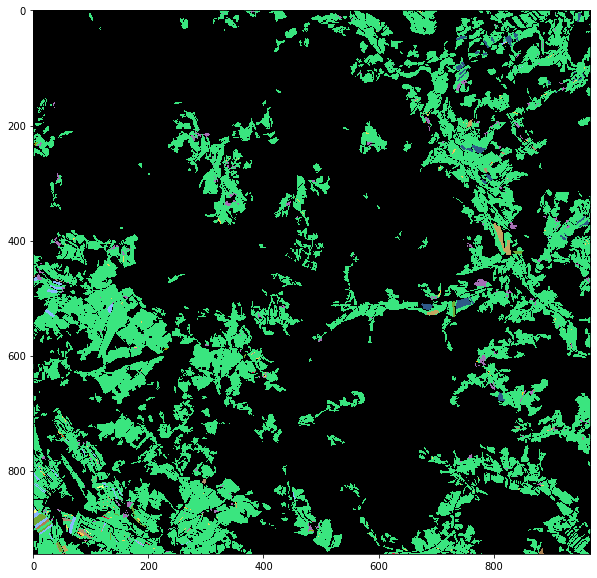

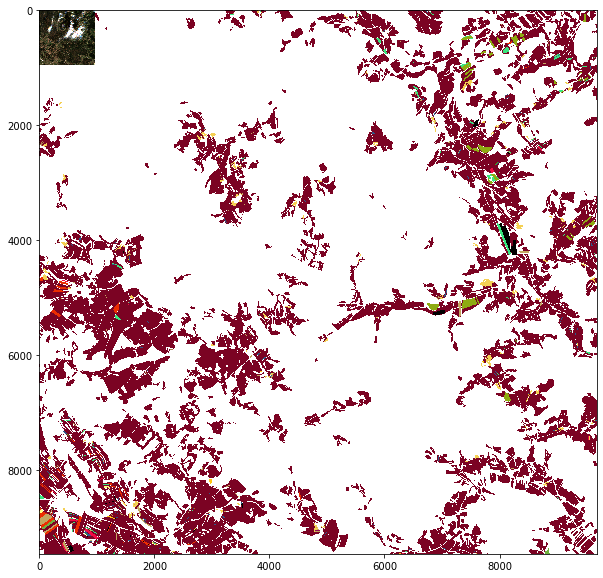

In [41]:
%matplotlib inline
import matplotlib

custom_colors = matplotlib.colors.ListedColormap(['xkcd:Black', # no class #NA
                'xkcd:reddish purple', # pesa #NA
                'xkcd:camouflage green', # kosen travnik
                'xkcd:sandy brown', # praha #NA
                'xkcd:pea green', # grah #NA
                'xkcd:lawn green', # pasnik #NA
                'xkcd:leaf', # hmelj
                'xkcd:light navy blue', #pale olive green', # trave
                'xkcd:tomato red', # mak #NA
                'xkcd:sandy brown', # ozimna oljna ogrscica mustard yellow
                'xkcd:maize', # 10 koruza
                'xkcd:carolina blue', # ozimna zita wheat
                'xkcd:soft purple', # metuljcnice deteljica
                'xkcd:pumpkin orange', # buce
                'xkcd:cranberry', # jagodicevje #NA
                'xkcd:golden', #15 jara zita
                'xkcd:sunflower', # soncnice #NA
                'xkcd:pinkish red', # zelenjava
                'xkcd:pale brown', # ajda #NA
                'xkcd:nasty green', # gorski travnik #NA
                'xkcd:light brown', # krompir
                'xkcd:pea soup', # strocnice #NA
                'xkcd:wine red', # vinogradi
                'xkcd:weird green', # drugo
                'xkcd:pale yellow', # soja
                'xkcd:browny orange' # sadno drevje
                ])

image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(eopatch.mask_timeless['LPIS_2017'])
mask_test = np.squeeze(eopatch.mask_timeless['TEST'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image)
ax0.imshow(mask, cmap=custom_colors, alpha=1)

fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.imshow(image)
ax1.imshow(mask_test, cmap=custom_colors, alpha=1)

In [39]:
maska1 = mask.flatten()
maska2 = mask_test.flatten()

In [40]:
maska1 = list(maska1)
maska2 = list(maska2)

In [41]:
[[x,maska1.count(x)] for x in set(maska1)]

[[0, 701134],
 [139, 99],
 [140, 51],
 [146, 38],
 [23, 634],
 [24, 291],
 [154, 5],
 [27, 14],
 [157, 202262],
 [29, 20],
 [159, 764],
 [162, 1288],
 [164, 17],
 [166, 65],
 [42, 58],
 [45, 15],
 [46, 680],
 [177, 4],
 [52, 2065],
 [53, 19],
 [56, 2],
 [58, 27],
 [69, 771],
 [75, 1434],
 [82, 688],
 [84, 2731],
 [86, 50],
 [113, 10],
 [115, 18],
 [119, 39],
 [120, 8],
 [123, 56],
 [125, 93],
 [126, 255]]

In [42]:
[[x,maska2.count(x)] for x in set(maska2)]

[[0, 70094798],
 [139, 9960],
 [140, 5036],
 [146, 4027],
 [23, 63922],
 [24, 29383],
 [154, 411],
 [27, 1376],
 [157, 20238970],
 [29, 1732],
 [159, 76239],
 [162, 131299],
 [164, 1682],
 [166, 6640],
 [42, 5579],
 [45, 1430],
 [46, 68710],
 [177, 476],
 [52, 206232],
 [53, 2070],
 [56, 134],
 [58, 2583],
 [69, 77871],
 [75, 142658],
 [82, 69046],
 [84, 274461],
 [86, 5269],
 [113, 975],
 [115, 2056],
 [119, 4052],
 [120, 854],
 [123, 5412],
 [125, 9082],
 [126, 26075]]

In [113]:
beets1_set = [101, 19]
meadows2_set = [204]
fallow_land3_set = [26]
peas4_set = [44, 33, 833]
pasture5_set = []
hop6_set = [900]
grass7_set = [118, 505, 201, 200, 202, 117]
poppy8_set = [31, 831]
winter_rape9_set = [812, 814]
maize10_set = [6, 5, 109, 49]
winter_cereals11_set = [809, 808, 803, 801, 802, 24, 825, 807]
leafy_legumes12_set = [220, 207, 206, 219, 211, 222, 208, 223, 221, 203]
pumpkins13_set = [42, 13]
soft_fruits14_set = [652, 681, 657, 679, 656, 660, 659, 651, 653, 655, 662, 654, 678]
summer_cereals15_set = [9, 11, 811, 8, 3, 10, 1, 2, 25, 7]
sunflower16_set = [12]
vegetables17_set = [46, 47, 48, 402]
buckwheat18_set = [4]
alpine_meadows19_set = []
potatoes20_set = [20]
beans21_set = [45, 17]
vineyards22_set = [707, 661, 706, 100]
other23_set = [115, 37, 738, 733, 648, 32, 111, 646, 555, 43, 675, 702, 114, 721, 619, 615, 110, 810,
            720, 35, 835, 27, 112, 102, 104, 804, 105, 106, 107, 28, 40, 41, 405, 710, 699, 705, 409,
            506, 722, 999, 904, '204_a', 0, 888, 404, 735, 14, 113, 103, 108, 777, 734, 649, 403, 36,
            34, 998, 737, 677, 21, 821, 116, 680, 703, 333, 723, 704, 29, 210, 736]
soybean24_set = [30]
orchards25_set = [621, 625, 672, 612, 611, 627, 643, 642, 676, 644, 613, 632, 671, 674, 633, 624, 658,
            614, 622, 616, 800, 631, 698, 673, 623, 647, 626, 618]




In [120]:
tmp_patch = eopatch.__copy__()
num_of_cells = tmp_patch['mask_timeless']['LPIS_multi'].shape[0]
out_arr = np.zeros((num_of_cells, 100, 1))
for i in range(0, num_of_cells):
    for j in range(0, 100):
        val = tmp_patch['mask_timeless']['LPIS_multi'][i][j][0]
        
        if(val in beets1_set):
            out_arr[i][j][0] = 1
        elif(val in meadows2_set):
            out_arr[i][j][0] = 2
        elif(val in fallow_land3_set):
            out_arr[i][j][0] = 3
        elif(val in peas4_set):
            out_arr[i][j][0] = 4
        elif(val in pasture5_set):
            out_arr[i][j][0] = 5
        elif(val in hop6_set):
            out_arr[i][j][0] = 6
        elif(val in grass7_set):
            out_arr[i][j][0] = 7
        elif(val in poppy8_set):
            out_arr[i][j][0] = 8
        elif(val in winter_rape9_set):
            out_arr[i][j][0] = 9
        elif(val in maize10_set):
            out_arr[i][j][0] = 10
        elif(val in winter_cereals11_set):
            out_arr[i][j][0] = 11
        elif(val in leafy_legumes12_set):
            out_arr[i][j][0] = 12
        elif(val in pumpkins13_set):
            out_arr[i][j][0] = 13
        elif(val in soft_fruits14_set):
            out_arr[i][j][0] = 14
        elif(val in summer_cereals15_set):
            out_arr[i][j][0] = 15
        elif(val in sunflower16_set):
            out_arr[i][j][0] = 16
        elif(val in vegetables17_set):
            out_arr[i][j][0] = 17
        elif(val in buckwheat18_set):
            out_arr[i][j][0] = 18
        elif(val in alpine_meadows19_set):
            out_arr[i][j][0] = 19
        elif(val in potatoes20_set):
            out_arr[i][j][0] = 20
        elif(val in beans21_set):
            out_arr[i][j][0] = 21
        elif(val in vineyards22_set):
            out_arr[i][j][0] = 22
        elif(val in other23_set):
            out_arr[i][j][0] = 23
        elif(val in soybean24_set):
            out_arr[i][j][0] = 24
        elif(val in orchards25_set):
            out_arr[i][j][0] = 25
        else:
            print(tmp_patch['mask_timeless']['LPIS_multi'][i][j][0])
eopatch['mask_timeless']['LPIS_multi_popravljeno'] = out_arr      

/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/eodata.py:247: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  new_eopatch[feature_type][feature_name] = self[feature_type][feature_name]
/Users/markbogataj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this


In [67]:
orchards25_set = set((1,2,3))

In [83]:
beets1_set = [101, 19, '204_a']

In [87]:
12 in beets1_set

False

In [118]:
eopatch['mask_timeless']['LPIS_multi'].shape[0]

5180

In [125]:
eopatch.mask_timeless

{'LPIS_multi': array([[[204.],
         [204.],
         [204.],
         ...,
         [204.],
         [204.],
         [204.]],
 
        [[204.],
         [204.],
         [204.],
         ...,
         [204.],
         [204.],
         [204.]],
 
        [[  0.],
         [204.],
         [204.],
         ...,
         [204.],
         [204.],
         [204.]],
 
        ...,
 
        [[204.],
         [204.],
         [204.],
         ...,
         [204.],
         [204.],
         [204.]],
 
        [[204.],
         [204.],
         [204.],
         ...,
         [204.],
         [204.],
         [204.]],
 
        [[204.],
         [204.],
         [204.],
         ...,
         [204.],
         [204.],
         [204.]]]), 'LPIS_sifra': array([[[2]],
 
        [[2]],
 
        [[2]],
 
        ...,
 
        [[2]],
 
        [[2]],
 
        [[2]]]), 'PID': array([[[2267899]],
 
        [[2267899]],
 
        [[2271055]],
 
        ...,
 
        [[3437825]],
 
        [[3437